# Analyse preds

In [1]:
import torch as th
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils.utils_pixel import *
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import geopandas as gpd
import contextily as cx

/dccstor/cimf/drought_impact/drought/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
exp =   'filtered_clean' #'nofilter' #
batch = 0
batch_size = 40 
epoch = 0
n_batches = 42
sample_type = 'pixel_data'
setup =  'final10_filter_26-02-2023_0.0001041_2_32' #'final_filter_23-02-2023_0.0001041_2_32' #'all_filter_23-02-2023_0.0001041_2_32'##'simple_cp_17-02-2023_0.00129_2_96'#'all_filter_19-02-2023_0.0001041_2_32' #'simple_cleanfilt_20-02-2023_0.00038_1_120' #"lasso_all_22-02-2023_0.0001041_2_32" #'sen_filter_20-02-2023_0.0001041_2_32' # 
split = 'val'

### Get dates

In [3]:
metadata_path = f'pixel_data/nofilter/{split}/'

In [4]:
# Get date/range of pred
all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])
full_date_range_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('full_date_range')])

In [5]:
all_loc_dates = []

for f in all_loc_dates_files:
    with open(metadata_path+f, 'rb') as f :
        all_loc_dates += pickle.load(f)
        
full_date_range = []

for f in full_date_range_files:
    with open(metadata_path+f, 'rb') as f :
        full_date_range += pickle.load(f)

In [6]:
n_rep = 4000/len(all_loc_dates)
idx_start = int(np.floor((batch_size*batch)/n_rep))
idx_last = int(np.floor((batch_size*batch + batch_size)/n_rep))

In [109]:
print('Dates of start of batch:')
print(all_loc_dates[idx_start][1])
print(all_loc_dates[idx_start][3])

Dates of start of batch:
['2021-05-04', '2021-05-14', '2021-05-24', '2021-06-03', '2021-06-13', '2021-06-23', '2021-07-03', '2021-07-13', '2021-07-23']
['2021-08-02', '2021-08-12', '2021-08-22']


### Load pred and label

In [45]:
pred_path = f'pixel_data/{exp}/preds/{split}/{setup}_data_cube_b{batch}.pt'
#pred_path = f'pixel_data/{exp}/preds_cp/{split}/{setup}_data_cube_b{batch}.pt'
pred = th.load(pred_path)

In [46]:
img, label = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp=exp, n_timesteps_out=1)

### Plot label and pred

In [47]:
label_ndvi = label[:,:,15,:,:].squeeze(0).squeeze(0).squeeze(1).squeeze(1).squeeze(1)

In [48]:
pred_ndvi = pred[:,:,0].detach()

In [49]:
metadata_path = f'pixel_data/nofilter/{split}/'
split_path = f'/dccstor/cimf/drought_impact/pixel_based/pixel_data/filtered/{split}/'
with open(split_path+'cloud_free_samples.pkl', 'rb') as f:
    cloud_free_samples = pickle.load(f)

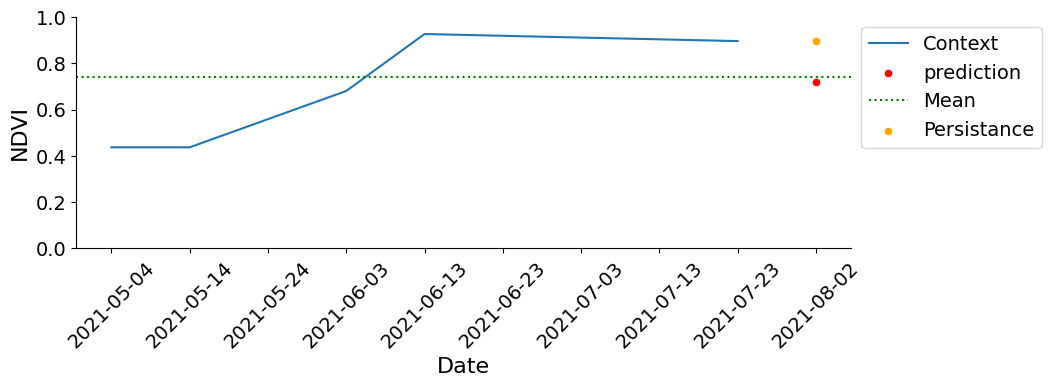

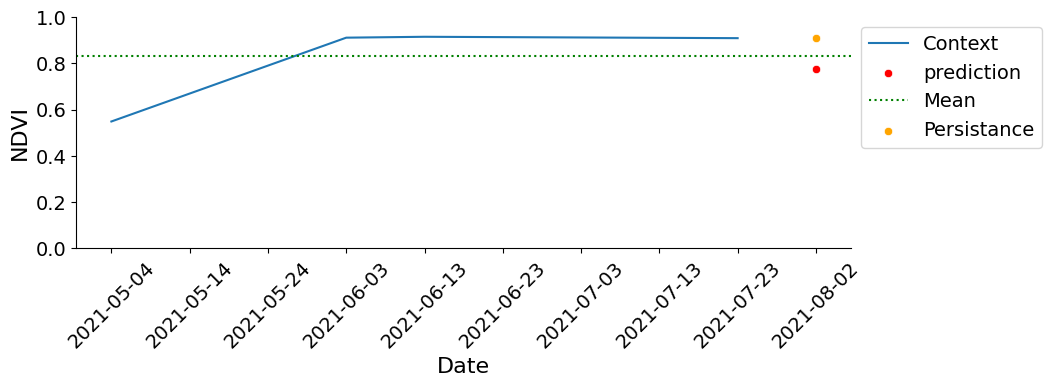

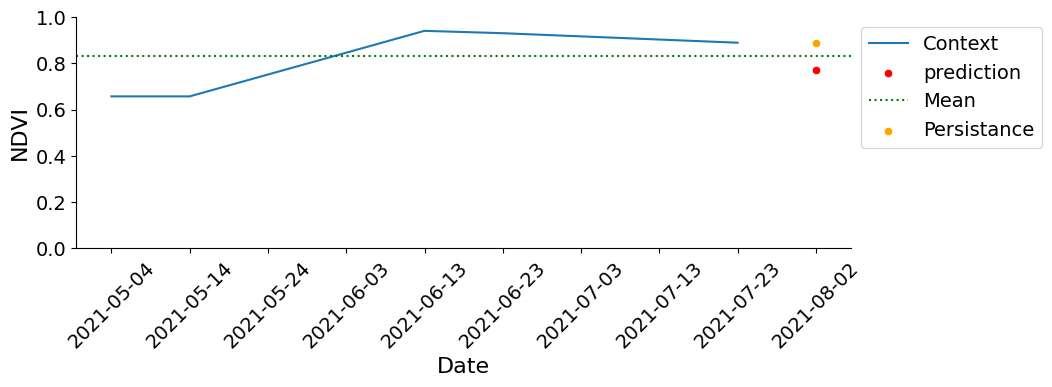

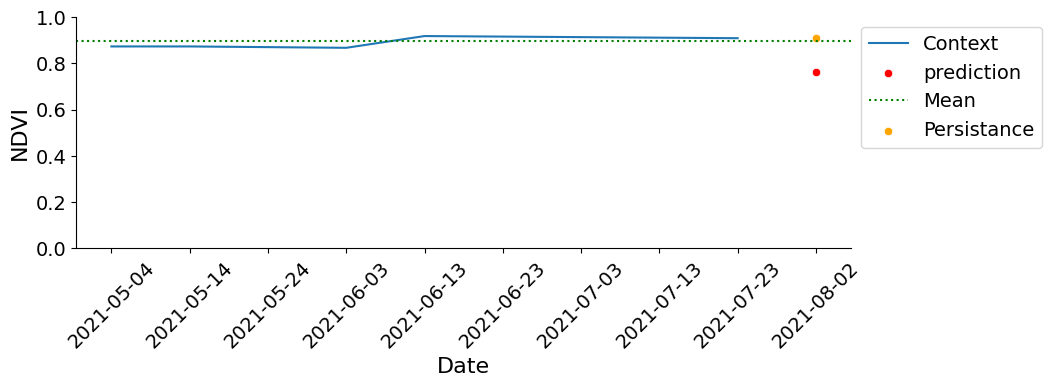

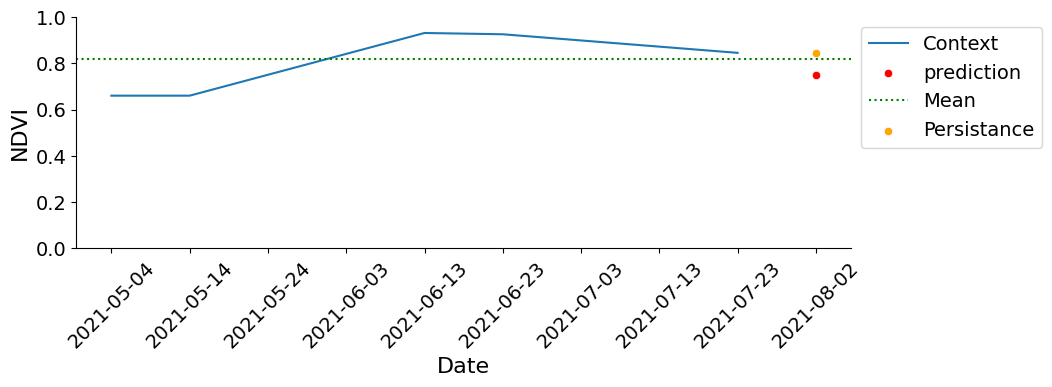

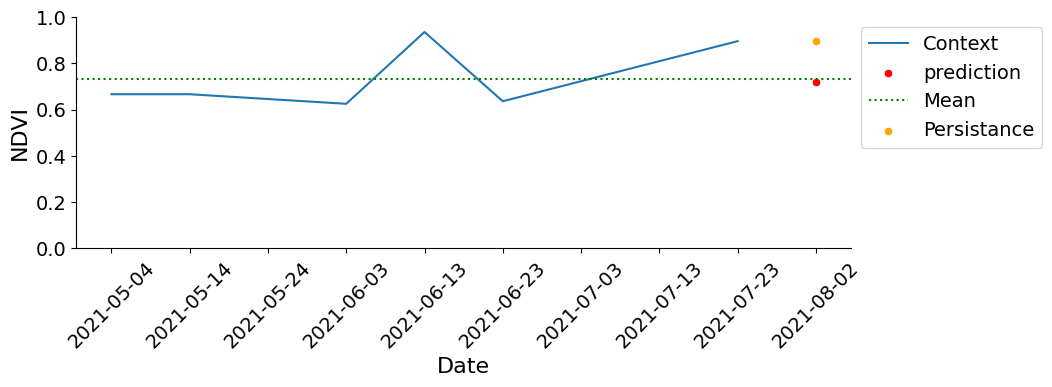

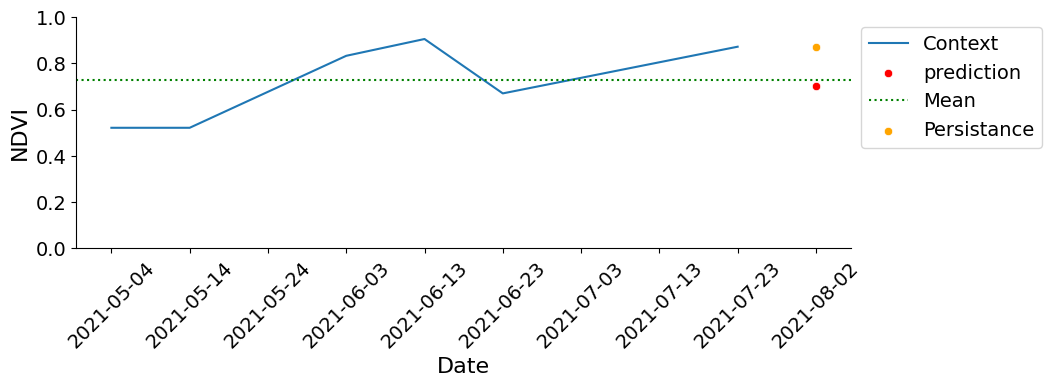

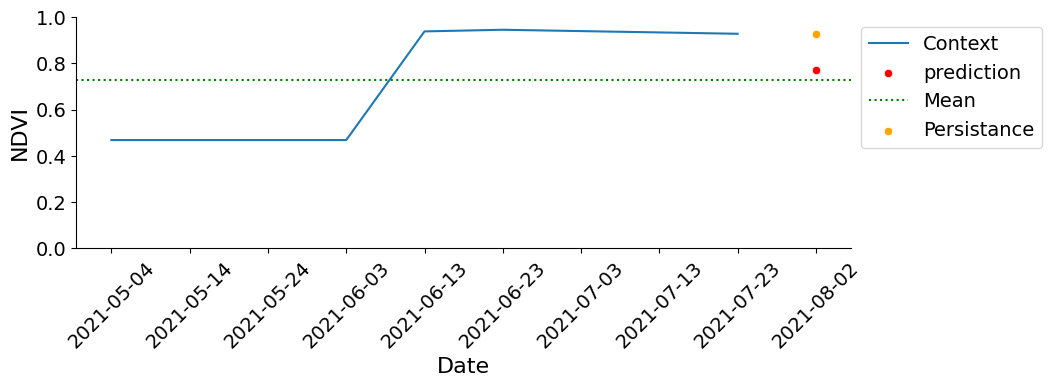

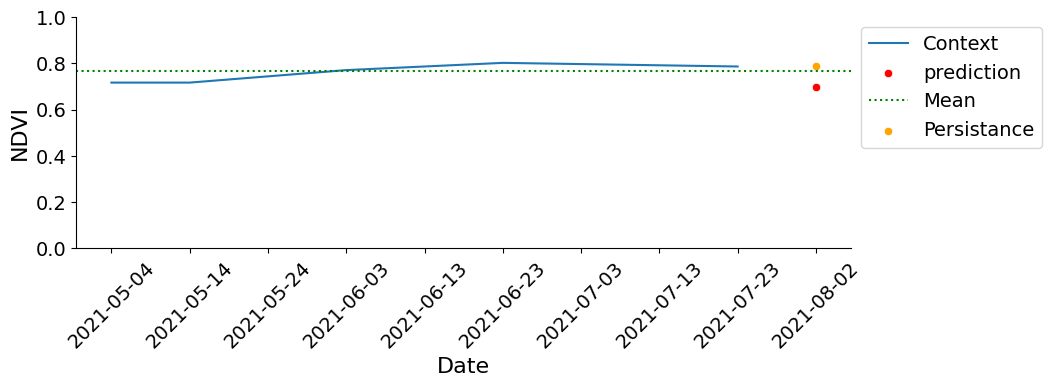

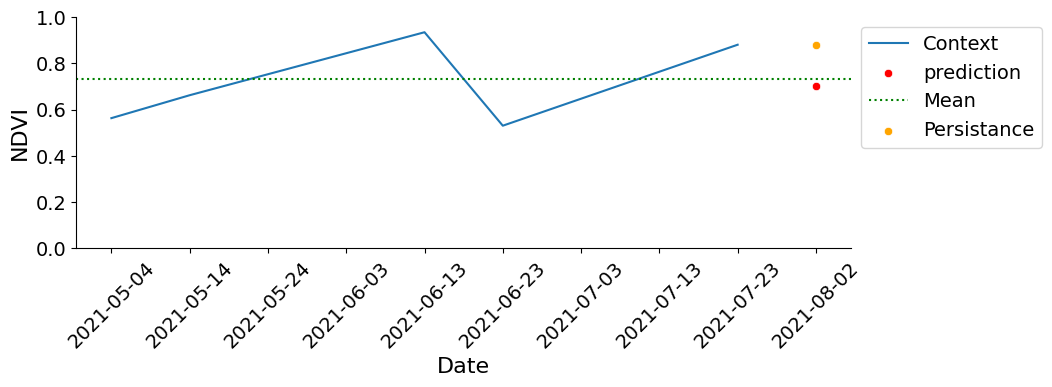

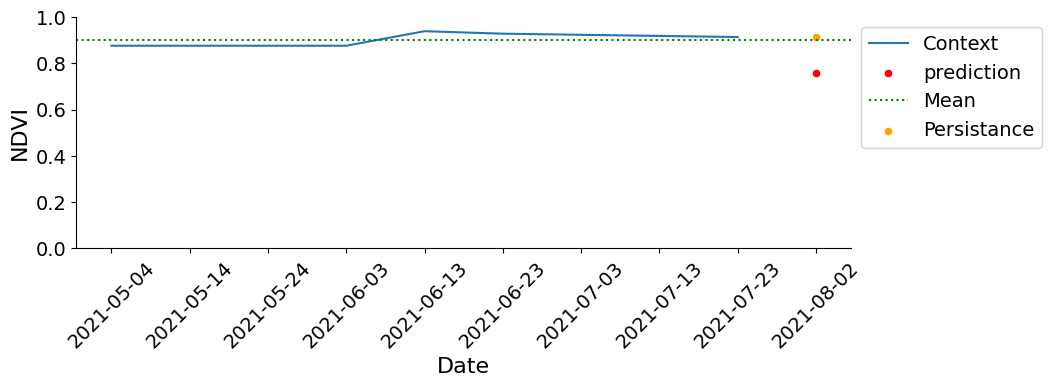

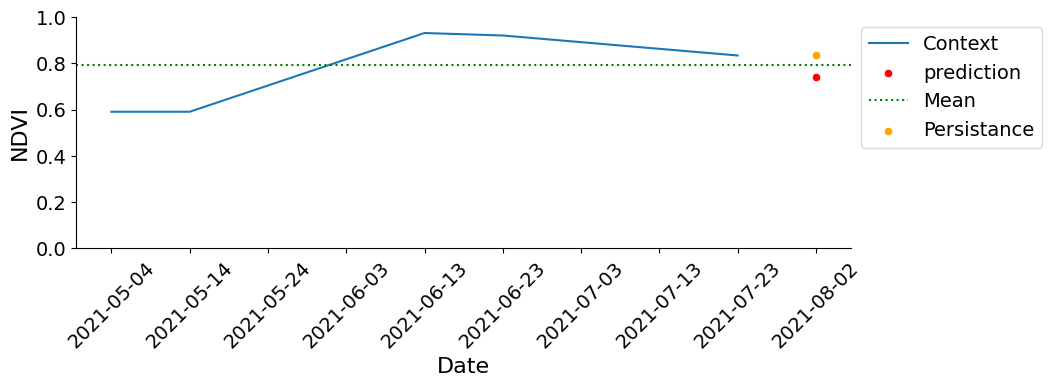

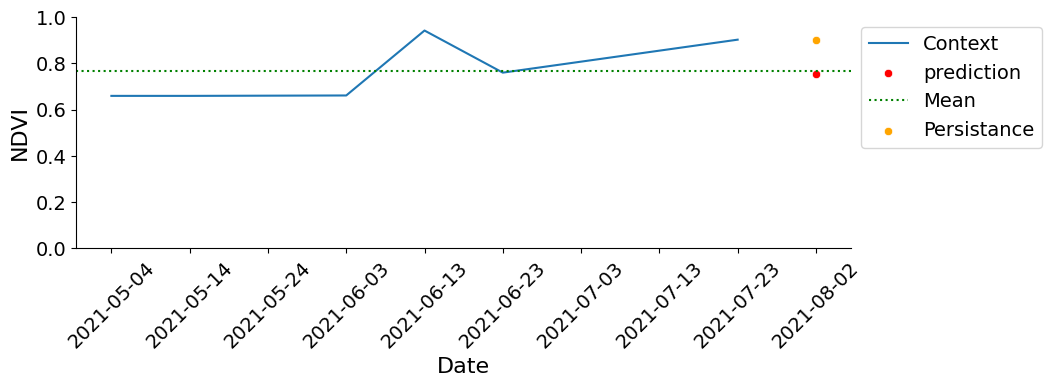

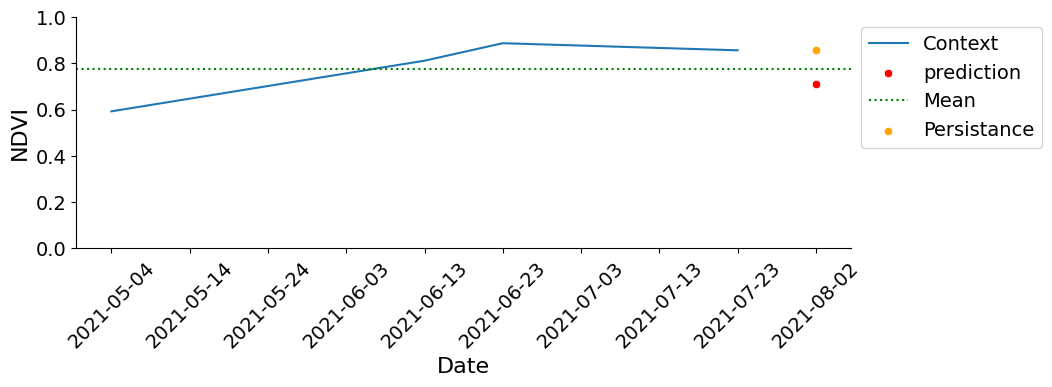

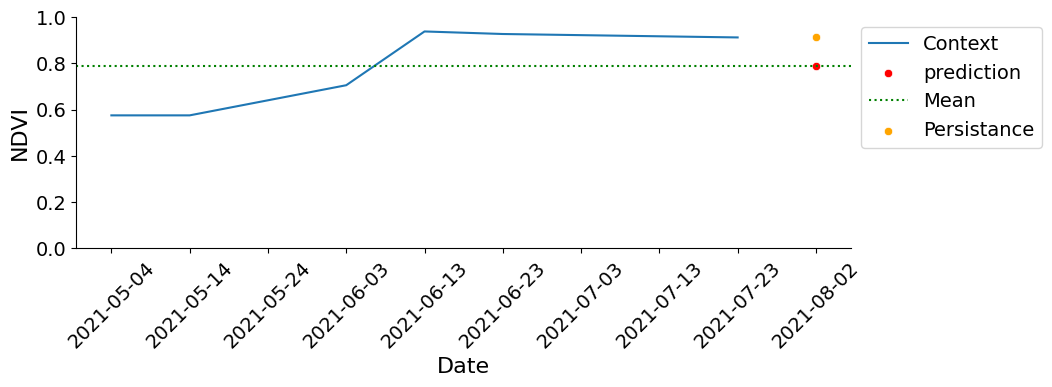

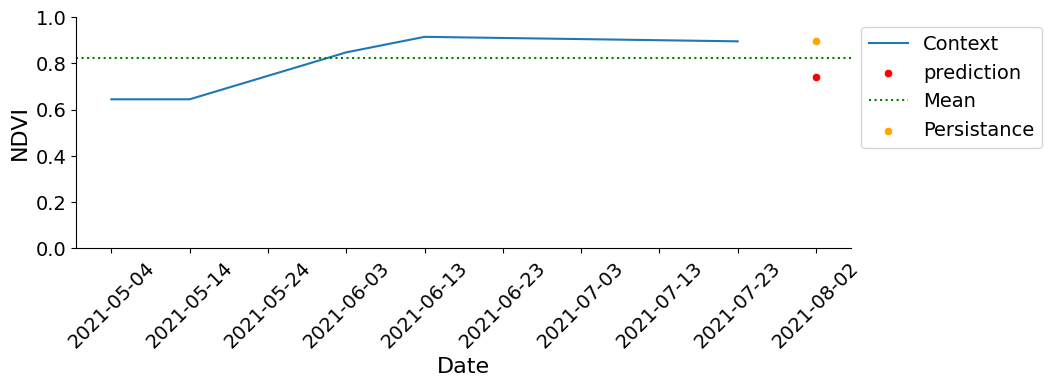

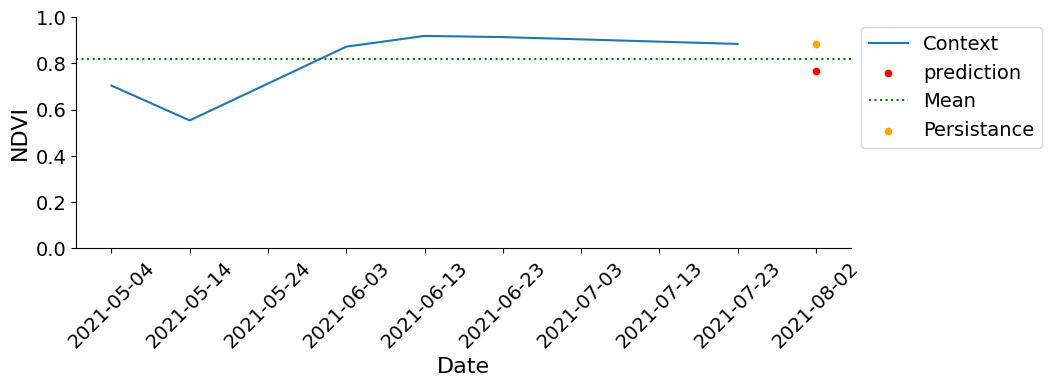

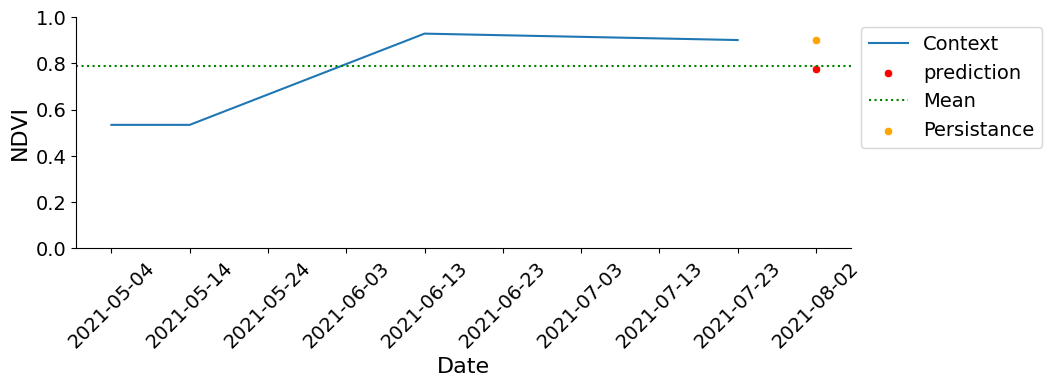

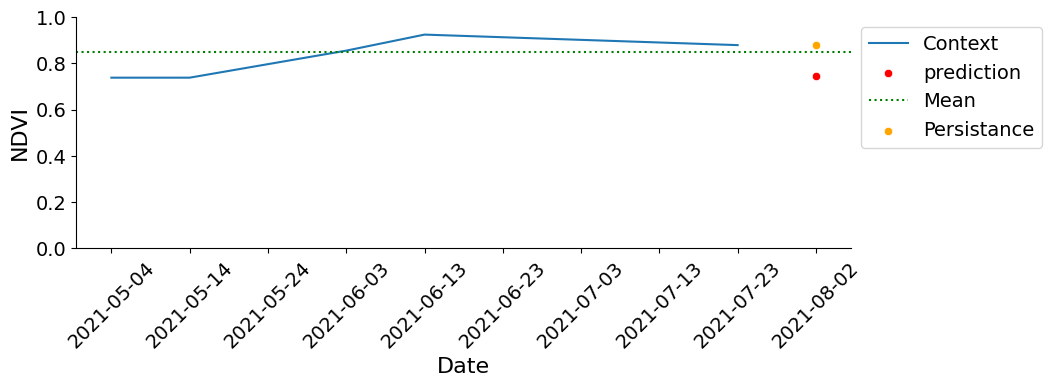

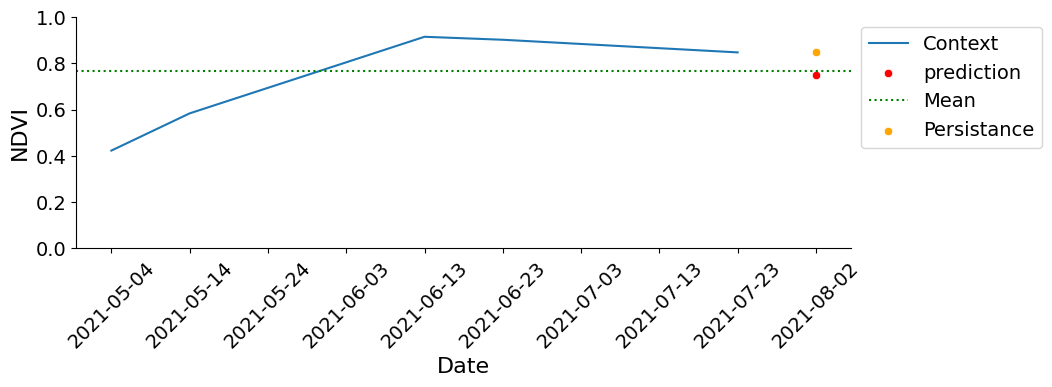

In [51]:
# Plot timeseries of a single pixel (CP)

for sample_id in range(20):
    ndvi_input = img[sample_id, :, 15, :, :].squeeze(1).squeeze(1)
    ndvi_label = label[sample_id, :, 15, :, :].squeeze(1).squeeze(1)
    ndvi_cleaned = th.cat([ndvi_input, ndvi_label])
    
    #dates = all_loc_dates[idx_start][1] + all_loc_dates[idx_start][3][:1]
    filtered_idx = int(np.floor(cloud_free_samples[batch*batch_size+sample_id]/n_rep))
    dates = all_loc_dates[filtered_idx][1] + all_loc_dates[filtered_idx][3][:1]

    pix_pred = pred_ndvi[sample_id].detach().cpu()
    tensor_of_nans = th.full(ndvi_input.shape, float('nan'))
    pix_pred = th.cat([tensor_of_nans, pix_pred])

    fig, ax = plt.subplots(1,1,figsize=(10,3))
    #plt.title('Pixel timeseries NDVI')
    sns.lineplot(ax=ax, y=ndvi_cleaned[:-1], x=dates[:-1],label='Context', color='tab:blue')
    """
    label_pt = np.empty(ndvi_cleaned.shape)
    label_pt[:] = np.nan
    label_pt[-1] = ndvi_cleaned[-1]
    sns.scatterplot(ax=ax, y=label_pt, x=dates,label='Label', color='tab:blue')
    """
    # add dot of predicted NDVI 
    sns.scatterplot(ax=ax, y=pix_pred, x=dates,label='prediction', color='red')
    # add mean and median
    plt.axhline(y = ndvi_input.mean(), color = 'green', linestyle = ':', label='Mean')
    #plt.axhline(y = ndvi_input.median(), color = 'green', linestyle = '--', label='median')
    # add dot of persistance prediction  
    pix_pers = ndvi_input[-1].detach().unsqueeze(0)
    tensor_of_nans = th.full(ndvi_input.shape, float('nan'))
    pix_pers = th.cat([tensor_of_nans, pix_pers])
    sns.scatterplot(ax=ax, y=pix_pers, x=dates,label='Persistance', color='orange')
    
    plt.xlabel('Date', size=16)
    plt.ylabel('NDVI', size=16)
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
    plt.xticks(rotation=45)
    sns.despine(top=True, right=True)
    ax.tick_params(axis='both', which='major', labelsize=14)

# Residuals

In [3]:
def get_pred_label(split, batch_size, n_batches, sample_type, exp, setup):
    
    y_pred_all = list()
    label_all = list()
    
    for batch_nbr in range(n_batches):
        pred_path = f'pixel_data/{exp}/preds/{split}/{setup}_data_cube_b{batch_nbr}.pt'
        #pred_path = f'pixel_data/{exp}/preds_cp/{split}/{setup}_data_cube_b{batch_nbr}.pt'
        pred = th.load(pred_path)
        
        img, label = load_batch(batch_size = batch_size, batch_nbr = batch_nbr, sample_type = 'pixel_data', split=split, exp=exp, n_timesteps_out=1)
        
        label_ndvi = label[:,:,15,:,:].squeeze(0).squeeze(0).squeeze(1).squeeze(1).squeeze(1).cpu().detach().numpy()
        pred_ndvi = pred[:,:,0].cpu().detach().numpy()
       
        y_pred_all.append(pred_ndvi)
        label_all.append(label_ndvi)
        """
        label_cp = label[:,:,14,:,:].squeeze(0).squeeze(0).squeeze(1).squeeze(1).squeeze(1).cpu().detach().numpy()
        y_pred_all.append(pred_ndvi[label_cp<0.01])
        label_all.append(label_ndvi[label_cp<0.01])
        """
     
   
    return y_pred_all, label_all

In [4]:
split = 'test'
batch_size = 40
n_batches = 42 #100 #

y_pred_te, label_te = get_pred_label(split, batch_size, n_batches, sample_type, exp, setup)
y_pred_te = np.concatenate(y_pred_te).squeeze(1)
label_te = np.concatenate(label_te)

In [5]:
split = 'val'
batch_size = 40
n_batches = 58 #100 #

y_pred_val, label_val = get_pred_label(split, batch_size, n_batches, sample_type, exp, setup)
y_pred_val = np.concatenate(y_pred_val).squeeze(1)
label_val = np.concatenate(label_val)

In [6]:
split = 'train'
batch_size = 40
n_batches = 559 #1000 #

y_pred_train, label_train = get_pred_label(split, batch_size, n_batches, sample_type, exp, setup)
y_pred_train = np.concatenate(y_pred_train)
label_train = np.concatenate(label_train)

In [7]:
split = 'test_vaud'
batch_size = 40
n_batches = 96 #1000 #

y_pred_vaud, label_vaud = get_pred_label(split, batch_size, n_batches, sample_type, exp, setup)
y_pred_vaud = np.concatenate(y_pred_vaud)
label_vaud = np.concatenate(label_vaud)

In [8]:
split = 'test_valais'
batch_size = 40
n_batches = 63 #1000 #

y_pred_valais, label_valais = get_pred_label(split, batch_size, n_batches, sample_type, exp, setup)
y_pred_valais = np.concatenate(y_pred_valais)
label_valais = np.concatenate(label_valais)

In [9]:
df = pd.DataFrame(data=label_te, columns=['label'], index=np.arange(0,len(label_te),1))
df['pred'] = y_pred_te
df['set'] = ['test']*len(label_te)

df_val = pd.DataFrame(data=label_val, columns=['label'], index=np.arange(0,len(label_val),1))
df_val['pred'] = y_pred_val
df_val['set'] = ['val']*len(label_val)

df_tr = pd.DataFrame(data=label_train, columns=['label'], index=np.arange(0,len(label_train),1))
df_tr['pred'] = y_pred_train
df_tr['set'] = ['train']*len(label_train)

df_all = pd.concat([df_tr, df_val, df], axis=0, ignore_index=True)
df_all['res'] = df_all['label'] - df_all['pred']

In [10]:
df_vaud = pd.DataFrame(data=label_vaud, columns=['label'], index=np.arange(0,len(label_vaud),1))
df_vaud['pred'] = y_pred_vaud
df_vaud['set'] = ['test_vaud']*len(label_vaud)

df_valais = pd.DataFrame(data=label_valais, columns=['label'], index=np.arange(0,len(label_valais),1))
df_valais['pred'] = y_pred_valais
df_valais['set'] = ['test_valais']*len(label_valais)

df_gen = pd.concat([df_vaud, df_valais], axis=0, ignore_index=True)
df_gen['res'] = df_gen['label'] - df_gen['pred']

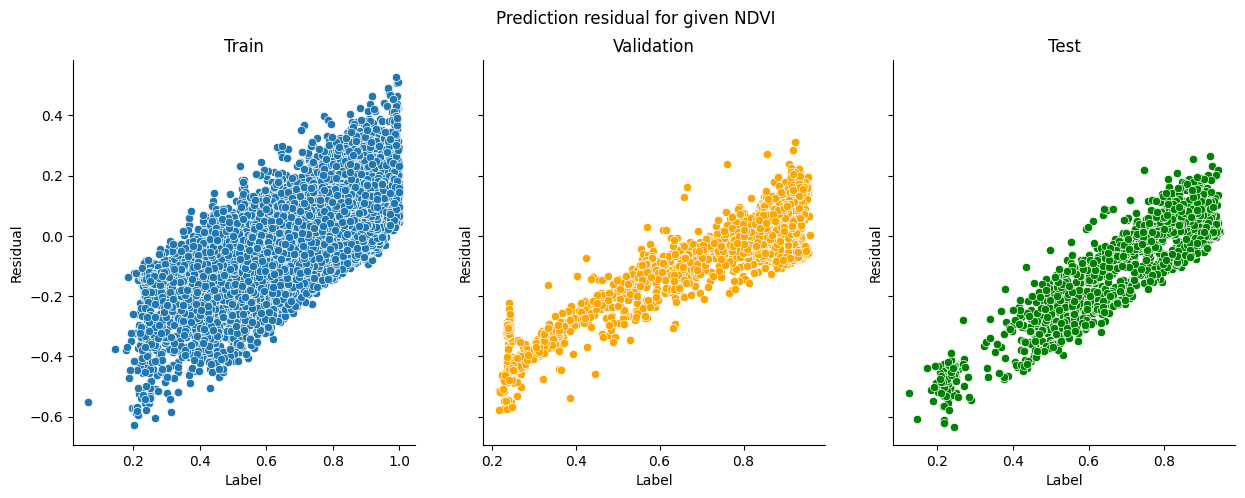

In [11]:
fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
plt.suptitle('Prediction residual for given NDVI')
axs[0].set_title('Train')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Residual')
sns.scatterplot(ax=axs[0], y='res', x='label', data=df_all[df_all.set=='train'])
axs[1].set_title('Validation')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Residual')
sns.scatterplot(ax=axs[1], y='res', x='label', data=df_all[df_all.set=='val'], color='orange')
axs[2].set_title('Test')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Residual')
sns.scatterplot(ax=axs[2], y='res', x='label', data=df_all[df_all.set=='test'],  color='green')
sns.despine(top=True, right=True)

y = 0.43x + -0.34
y = 0.64x + -0.55
y = 0.77x + -0.64


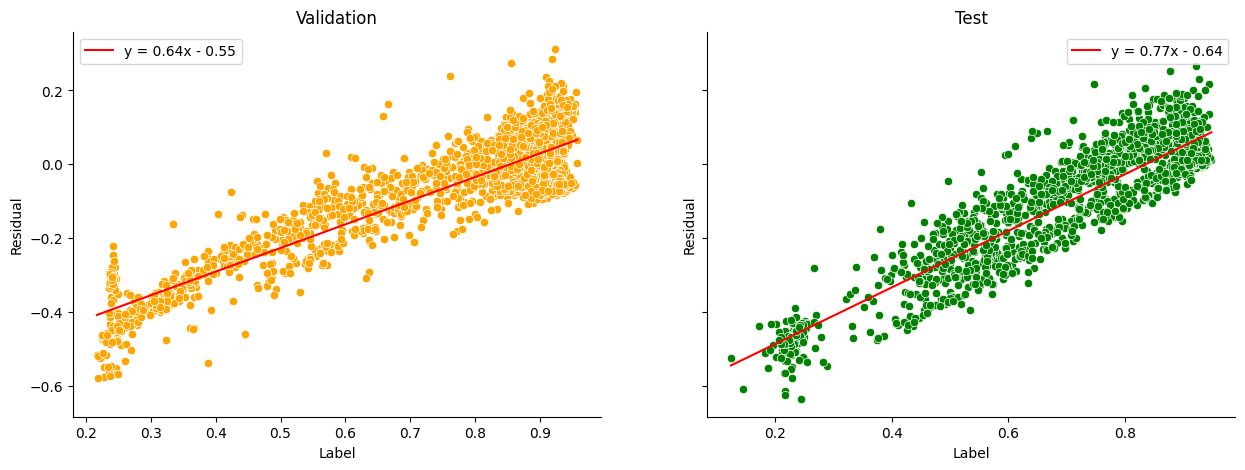

In [11]:
# Linear regression to fix residuals

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(df_all[df_all.set=='train'].label).reshape(-1, 1), np.array(df_all[df_all.set=='train'].res).reshape(-1, 1))
y_pred_tr = model.predict(np.array(df_all[df_all.set=='train'].label).reshape(-1, 1))
slope = model.coef_[0][0]
intercept = model.intercept_[0]
equation = f'y = {slope:.2f}x + {intercept:.2f}'
print(equation)

model = LinearRegression()
model.fit(np.array(df_all[df_all.set=='val'].label).reshape(-1, 1), np.array(df_all[df_all.set=='val'].res).reshape(-1, 1))
y_pred_val = model.predict(np.array(df_all[df_all.set=='val'].label).reshape(-1, 1))
slope = model.coef_[0][0]
intercept = model.intercept_[0]
equation = f'y = {slope:.2f}x + {intercept:.2f}'
print(equation)

model = LinearRegression()
model.fit(np.array(df_all[df_all.set=='test'].label).reshape(-1, 1), np.array(df_all[df_all.set=='test'].res).reshape(-1, 1))
y_pred_te = model.predict(np.array(df_all[df_all.set=='test'].label).reshape(-1, 1))
slope = model.coef_[0][0]
intercept = model.intercept_[0]
equation = f'y = {slope:.2f}x + {intercept:.2f}'
print(equation)

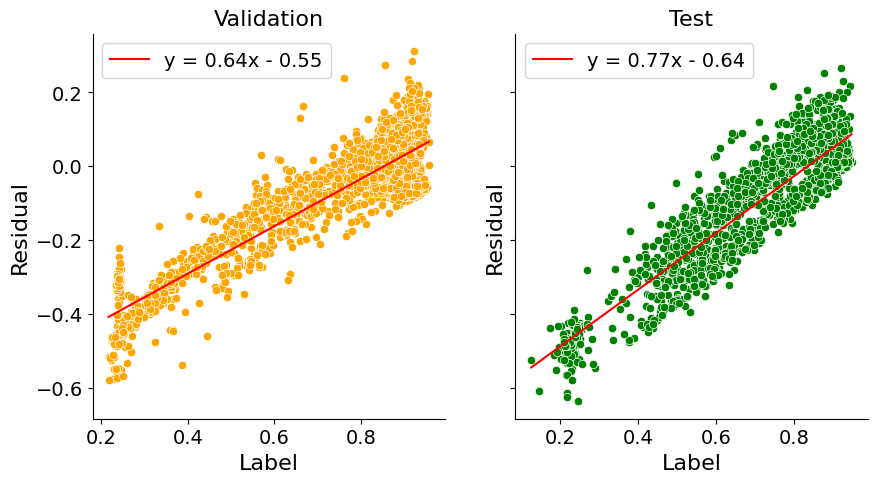

In [17]:

fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)
#plt.suptitle('Prediction residual for given NDVI')
#axs[0].set_title('Train')
#axs[0].set_xlabel('Label')
#axs[0].set_ylabel('Residual')
#sns.scatterplot(ax=axs[0], y='res', x='label', data=df_all[df_all.set=='train'])
#sns.lineplot(ax=axs[0], y=y_pred_tr.reshape(-1), x='label', data=df_all[df_all.set=='train'], color='red', label='y = 0.43x - 0.34')
axs[0].set_title('Validation', size=16)
axs[0].set_xlabel('Label', size=16)
axs[0].set_ylabel('Residual', size=16)
sns.scatterplot(ax=axs[0], y='res', x='label', data=df_all[df_all.set=='val'], color='orange')
sns.lineplot(ax=axs[0], y=y_pred_val.reshape(-1), x='label', data=df_all[df_all.set=='val'], color='red', label='y = 0.64x - 0.55')
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(fontsize=14)
axs[1].set_title('Test', size=16)
axs[1].set_xlabel('Label', size=16)
axs[1].set_ylabel('Residual', size=16)
sns.scatterplot(ax=axs[1], y='res', x='label', data=df_all[df_all.set=='test'],  color='green')
sns.lineplot(ax=axs[1], y=y_pred_te.reshape(-1), x='label', data=df_all[df_all.set=='test'], color='red', label='y = 0.77x - 0.64')
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=14)
sns.despine(top=True, right=True)

In [46]:
# Fix resids and recalculate losses
# for each label add the resid to the actually resid, then recalcul MSE

def fix_tr(label):
    return 0.43*label + -0.34

def fix_val(label):
    return 0.64*label + -0.55

def fix_test(label):
    return 0.77*label + -0.64


df_all["corrected_res"] = [0]*len(df_all)
corrected_res_tr = df_all[df_all.set=='train'].label.apply(lambda x: fix_tr(x))
corrected_res_val= df_all[df_all.set=='val'].label.apply(lambda x: fix_val(x))
corrected_res_te = df_all[df_all.set=='test'].label.apply(lambda x: fix_test(x))

df_all.loc[df_all.set=='train','corrected_res'] = corrected_res_tr
df_all.loc[df_all.set=='val','corrected_res'] = corrected_res_val
df_all.loc[df_all.set=='test','corrected_res']= corrected_res_te

df_all['pred_corrected'] = df_all['pred'] + df_all['corrected_res']

In [51]:
mse_val_new = mean_squared_error(df_all[df_all["set"]=='val'].label, df_all[df_all["set"]=='val'].pred_corrected)
mse_test_new = mean_squared_error(df_all[df_all["set"]=='test'].label, df_all[df_all["set"]=='test'].pred_corrected)
print(f'MSE val new {mse_val_new}, test {mse_test_new}')

MSE val new 0.004679368825119869, test 0.00508266382006001


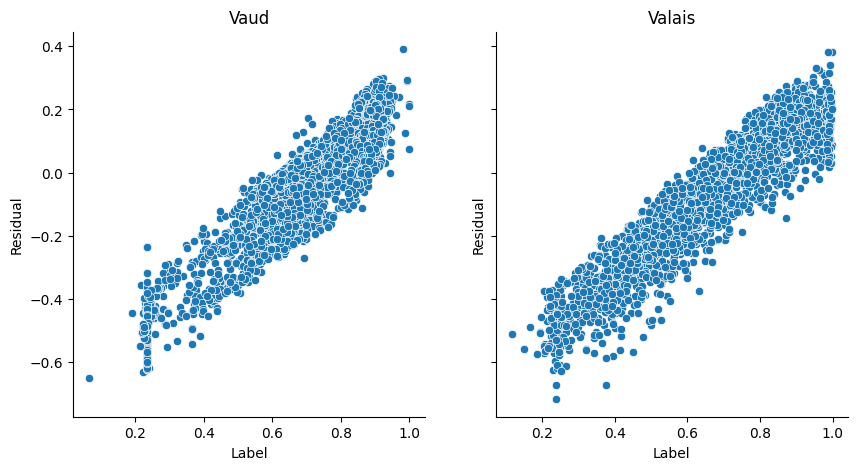

In [18]:
fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)
#plt.suptitle('Prediction residual for given NDVI')
axs[0].set_title('Vaud')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Residual')
sns.scatterplot(ax=axs[0], y='res', x='label', data=df_gen[df_gen.set=='test_vaud'])
axs[1].set_title('Valais')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Residual')
sns.scatterplot(ax=axs[1], y='res', x='label', data=df_gen[df_gen.set=='test_valais'])
sns.despine(top=True, right=True)

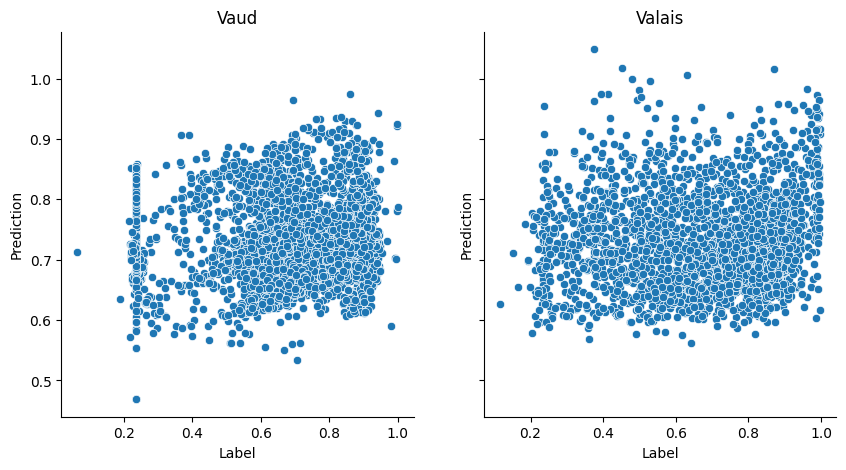

In [18]:
# Plot: pred vs label

fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)
#plt.suptitle('Label vs Prediction', size=14)
axs[0].set_title('Vaud')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Prediction')
sns.scatterplot(ax=axs[0], y='pred', x='label', data=df_gen[df_gen.set=='test_vaud'])
axs[1].set_title('Valais')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Prediction')
sns.scatterplot(ax=axs[1], y='pred', x='label', data=df_gen[df_gen.set=='test_valais'])
sns.despine(top=True, right=True)

In [19]:
# Calculate R2

r2_val = r2_score(df_all[df_all["set"]=='val'].label, df_all[df_all["set"]=='val'].pred)
r2_test = r2_score(df_all[df_all["set"]=='test'].label, df_all[df_all["set"]=='test'].pred)
r2_train = r2_score(df_all[df_all["set"]=='train'].label, df_all[df_all["set"]=='train'].pred)
r2_vaud = r2_score(df_gen[df_gen["set"]=='test_vaud'].label, df_gen[df_gen["set"]=='test_vaud'].pred)
r2_valais = r2_score(df_gen[df_gen["set"]=='test_valais'].label, df_gen[df_gen["set"]=='test_valais'].pred)
print(f'R2 train {r2_train}, val {r2_val}, test {r2_test}, vaud {r2_vaud}, valais {r2_valais}')

R2 train 0.5623154795353953, val 0.42561839491768694, test 0.06310432151174439, vaud -0.05429267047963959, valais -0.15548651433891036


In [129]:
# Calculate MSE
mse_val = mean_squared_error(df_all[df_all["set"]=='val'].label, df_all[df_all["set"]=='val'].pred)
mse_test = mean_squared_error(df_all[df_all["set"]=='test'].label, df_all[df_all["set"]=='test'].pred)
mse_train = mean_squared_error(df_all[df_all["set"]=='train'].label, df_all[df_all["set"]=='train'].pred)
mse_vaud = mean_squared_error(df_gen[df_gen["set"]=='test_vaud'].label, df_gen[df_gen["set"]=='test_vaud'].pred)
mse_valais = mean_squared_error(df_gen[df_gen["set"]=='test_valais'].label, df_gen[df_gen["set"]=='test_valais'].pred)
print(f'MSE train {mse_train}, val {mse_val}, test {mse_test}, vaud {mse_vaud}, valais {mse_valais}')

MSE train 0.012052289210259914, val 0.023551112040877342, test 0.037075527012348175, vaud 0.055832985788583755, valais 0.04714817926287651


In [21]:
# Calculate r2

import scipy.stats as stats

# Calculate Pearson's r correlation coefficient and the p-value
r_val, _ = stats.pearsonr(df_all[df_all["set"]=='val'].label, df_all[df_all["set"]=='val'].pred)
r_test, _ = stats.pearsonr(df_all[df_all["set"]=='test'].label, df_all[df_all["set"]=='test'].pred)
r_train, _ = stats.pearsonr(df_all[df_all["set"]=='train'].label, df_all[df_all["set"]=='train'].pred)
r_vaud, _ = stats.pearsonr(df_gen[df_gen["set"]=='test_vaud'].label, df_gen[df_gen["set"]=='test_vaud'].pred)
r_valais, _ = stats.pearsonr(df_gen[df_gen["set"]=='test_valais'].label, df_gen[df_gen["set"]=='test_valais'].pred)

# Print the results
print(f"Pearson's r: train {r_train}, val {r_val}, test {r_test}, vaud {r_vaud}, valais {r_valais}")
print(f"r2: train {r_train**2}, val {r_val**2}, test {r_test**2}, vaud {r_vaud**2}, valais {r_valais**2}")

Pearson's r: train 0.7498894810419313, val 0.7447148341744123, test 0.5523820159713587, vaud 0.18226187986823722, valais 0.05570299814621752
r2: train 0.562334233777337, val 0.5546001842394225, test 0.3051258915685824, vaud 0.033219392853103734, valais 0.0031028240024775127


# Plot residuals in time

In [22]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as plticker

In [23]:
def get_pred_label_time(split, batch_size, n_batches, sample_type, total_samples, exp, setup):
    
    y_pred_all = list()
    label_all = list()
    dates_all = list()
    
    metadata_path = f'pixel_data/nofilter/{split}/'
    split_path = f'/dccstor/cimf/drought_impact/pixel_based/pixel_data/filtered/{split}/'
    with open(split_path+'cloud_free_samples.pkl', 'rb') as f:
        cloud_free_samples = pickle.load(f)
        
    all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])
    all_loc_dates = []

    for f in all_loc_dates_files:
        with open(metadata_path+f, 'rb') as f :
            all_loc_dates += pickle.load(f)
    
    n_rep = total_samples/len(all_loc_dates)

    
    for batch_nbr in range(n_batches):
        pred_path = f'pixel_data/{exp}/preds/{split}/{setup}_data_cube_b{batch_nbr}.pt'
        pred = th.load(pred_path)
        
        img, label = load_batch(batch_size = batch_size, batch_nbr = batch_nbr, sample_type = 'pixel_data', split=split, exp=exp, n_timesteps_out=1)
        
        for sample_id in range(img.size(0)):
            filtered_idx = int(np.floor(cloud_free_samples[batch_nbr*batch_size+sample_id]/n_rep))
            dates = all_loc_dates[filtered_idx][3][:1]

            label_ndvi = label[sample_id,:,15,:,:].squeeze(1).squeeze(1).cpu().detach().numpy()
            pred_ndvi = pred[sample_id,:,0].cpu().detach().numpy()

            y_pred_all.append(pred_ndvi)
            label_all.append(label_ndvi)
            dates_all += dates

     
    return y_pred_all, label_all, dates_all

In [24]:
split = 'test'
batch_size = 40
n_batches = 42 #100 #
total_samples= 4000

y_pred_te, label_te, dates_te = get_pred_label_time(split, batch_size, n_batches, sample_type, total_samples, exp, setup)
y_pred_te = np.concatenate(y_pred_te)
label_te = np.concatenate(label_te)

In [25]:
split = 'val'
batch_size = 40
n_batches = 58 #100 #
total_samples= 4000

y_pred_val, label_val, dates_val = get_pred_label_time(split, batch_size, n_batches, sample_type, total_samples, exp, setup)
y_pred_val = np.concatenate(y_pred_val)
label_val = np.concatenate(label_val)

In [26]:
split = 'train'
batch_size = 40
n_batches = 559 #1000 #
total_samples= 40000

y_pred_train, label_train, dates_train = get_pred_label_time(split, batch_size, n_batches, sample_type, total_samples, exp, setup)
y_pred_train = np.concatenate(y_pred_train)
label_train = np.concatenate(label_train)

In [27]:
df_te = pd.DataFrame(data=label_te, columns=['label'], index=np.arange(0,len(label_te),1))
df_te['pred'] = y_pred_te
df_te['date'] = dates_te
df_te['set'] = ['test']*len(label_te)
df_te['res'] = df_te['label'] - df_te['pred']
df_te = df_te.sort_values('date')
df_te['date2'] = pd.to_datetime(df_te['date'])

df_val = pd.DataFrame(data=label_val, columns=['label'], index=np.arange(0,len(label_val),1))
df_val['pred'] = y_pred_val
df_val['date'] = dates_val
df_val['set'] = ['val']*len(label_val)
df_val['res'] = df_val['label'] - df_val['pred']
df_val = df_val.sort_values('date')
df_val['date2'] = pd.to_datetime(df_val['date'])

df_tr = pd.DataFrame(data=label_train, columns=['label'], index=np.arange(0,len(label_train),1))
df_tr['pred'] = y_pred_train
df_tr['date'] = dates_train
df_tr['set'] = ['train']*len(label_train)
df_tr['res'] = df_tr['label'] - df_tr['pred']
df_tr = df_tr.sort_values('date')
df_tr['date2'] = pd.to_datetime(df_tr['date'])

df_all = pd.concat([df_tr, df_val, df], axis=0, ignore_index=True)
#df_all['res'] = df_all['label'] - df_all['pred']
df_all = df_all.sort_values('date')
df_all['date2'] = pd.to_datetime(df_all['date'])

In [28]:
df_all.head()

label      pred        date    set       res      date2
0   0.557769  0.555556  2018-04-05  train  0.002213 2018-04-05
92  0.580984  0.521593  2018-04-05  train  0.059391 2018-04-05
93  0.227628  0.553923  2018-04-05  train -0.326295 2018-04-05
94  0.272449  0.495730  2018-04-05  train -0.223281 2018-04-05
95  0.656834  0.609049  2018-04-05  train  0.047785 2018-04-05

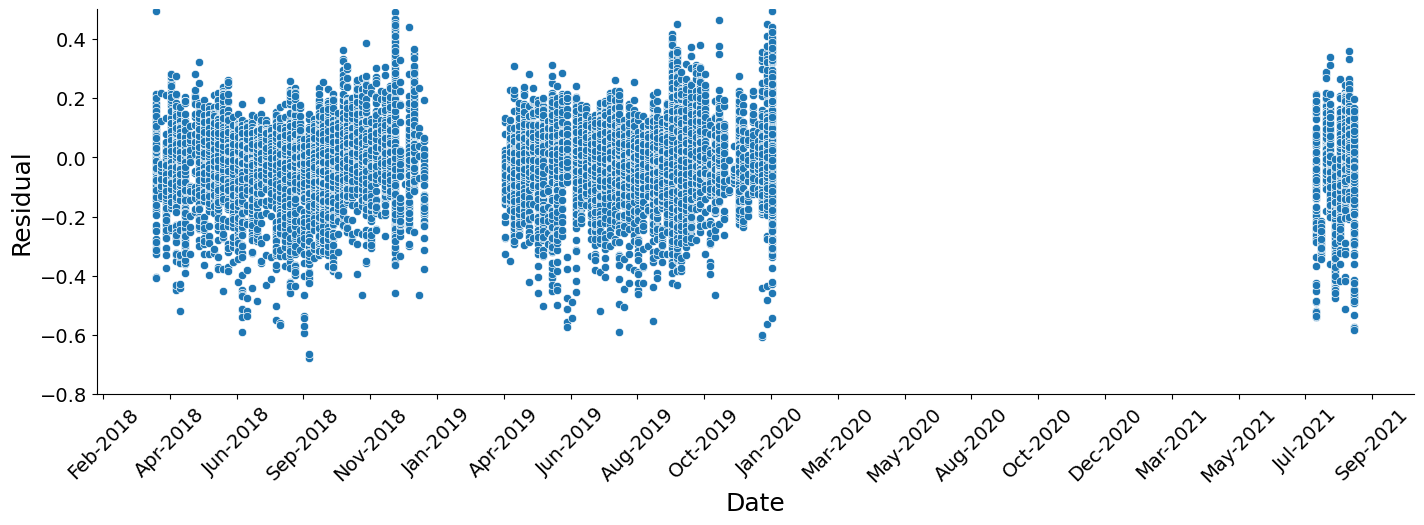

In [28]:
# Plot all years
fig, ax = plt.subplots(1,1,figsize=(17,5))
sns.scatterplot(data=df_all, x='date2', y='res')
plt.ylabel('Residual', size=18)
plt.xlabel('Date', size=18)
sns.despine(top=True, right=True)
plt.ylim(-0.8, 0.5)

loc = plticker.MultipleLocator(base=70) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Plot dates as year-month
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

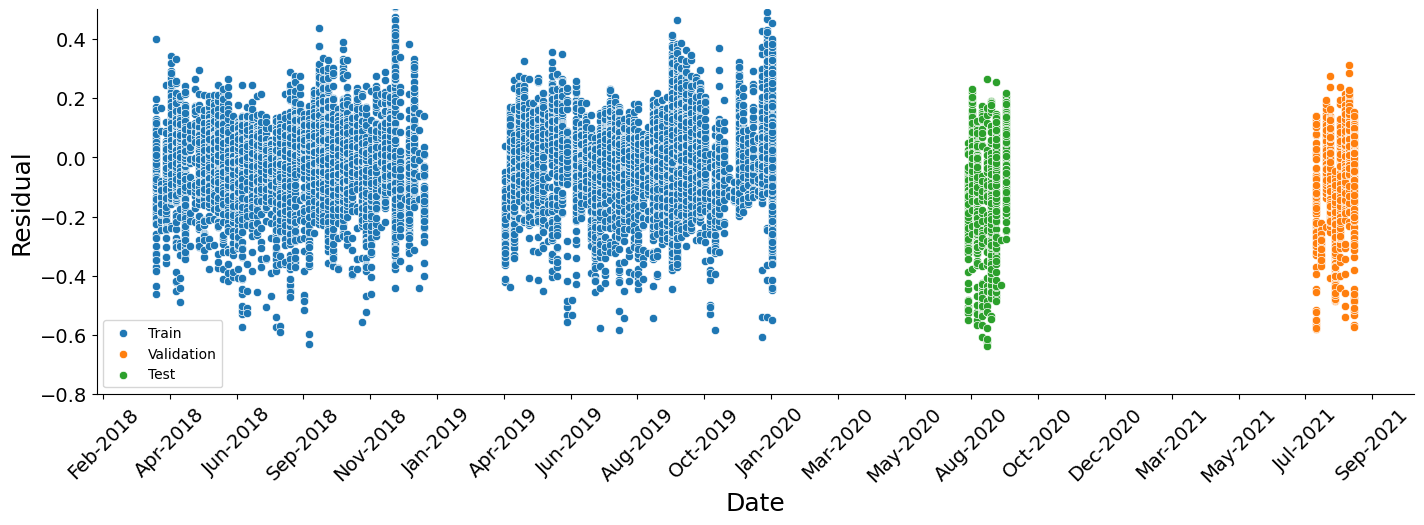

In [29]:
# Plot all years
fig, ax = plt.subplots(1,1,figsize=(17,5))
sns.scatterplot(data=df_tr, x='date2', y='res', label='Train')
sns.scatterplot(data=df_val, x='date2', y='res', label='Validation')
sns.scatterplot(data=df_te, x='date2', y='res', label='Test')
plt.ylabel('Residual', size=18)
plt.xlabel('Date', size=18)
sns.despine(top=True, right=True)
plt.ylim(-0.8, 0.5)

loc = plticker.MultipleLocator(base=70) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Plot dates as year-month
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

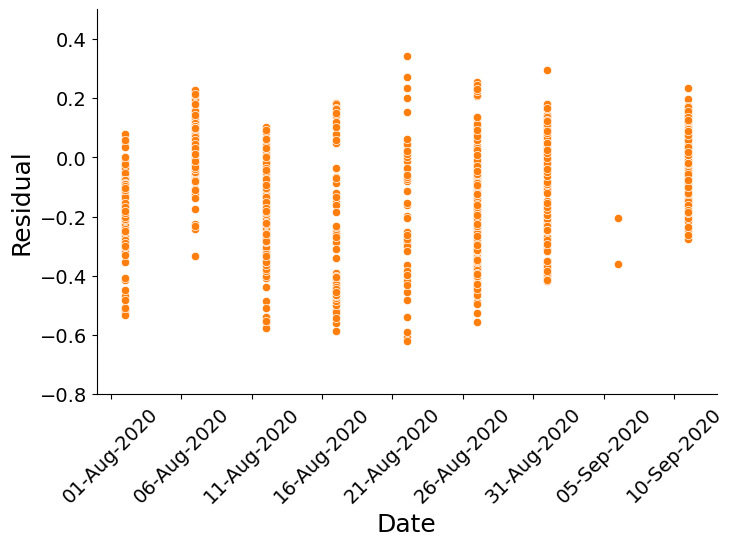

In [175]:
# Test
fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.scatterplot(data=df_te, x='date2', y='res', color='tab:orange')
plt.ylabel('Residual', size=18)
plt.xlabel('Date', size=18)
sns.despine(top=True, right=True)
plt.ylim(-0.8, 0.5)

loc = plticker.MultipleLocator(base=5) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Plot dates as year-month
date_form = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

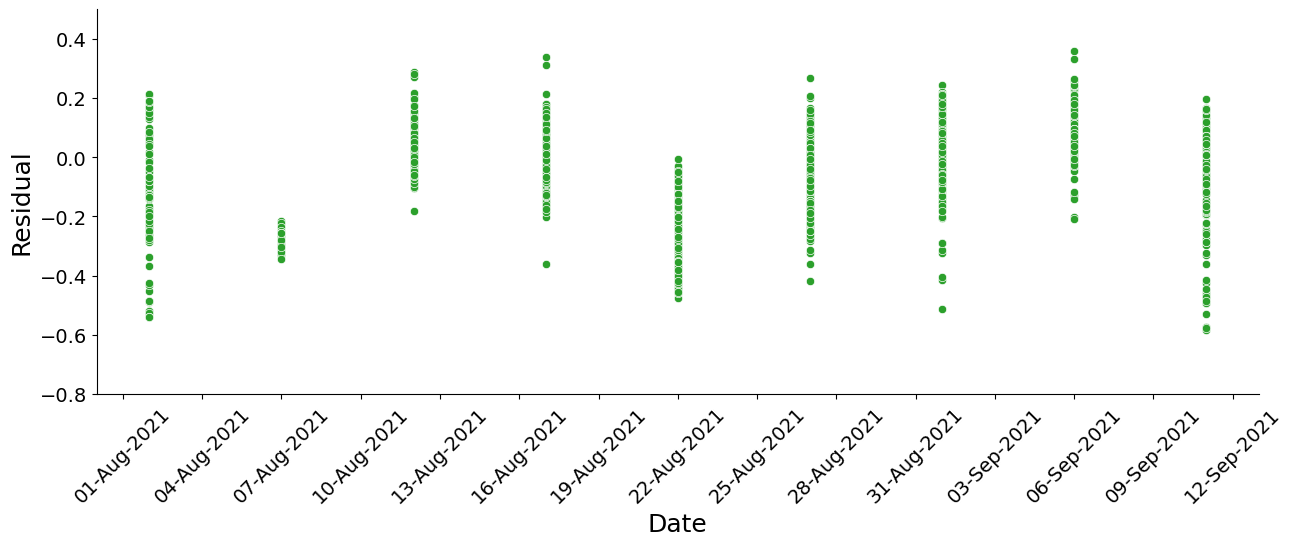

In [170]:
# Val
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=df_val, x='date2', y='res', color='tab:green')
plt.ylabel('Residual', size=18)
plt.xlabel('Date', size=18)
sns.despine(top=True, right=True)
plt.ylim(-0.8, 0.5)


loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Plot dates as year-month
date_form = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

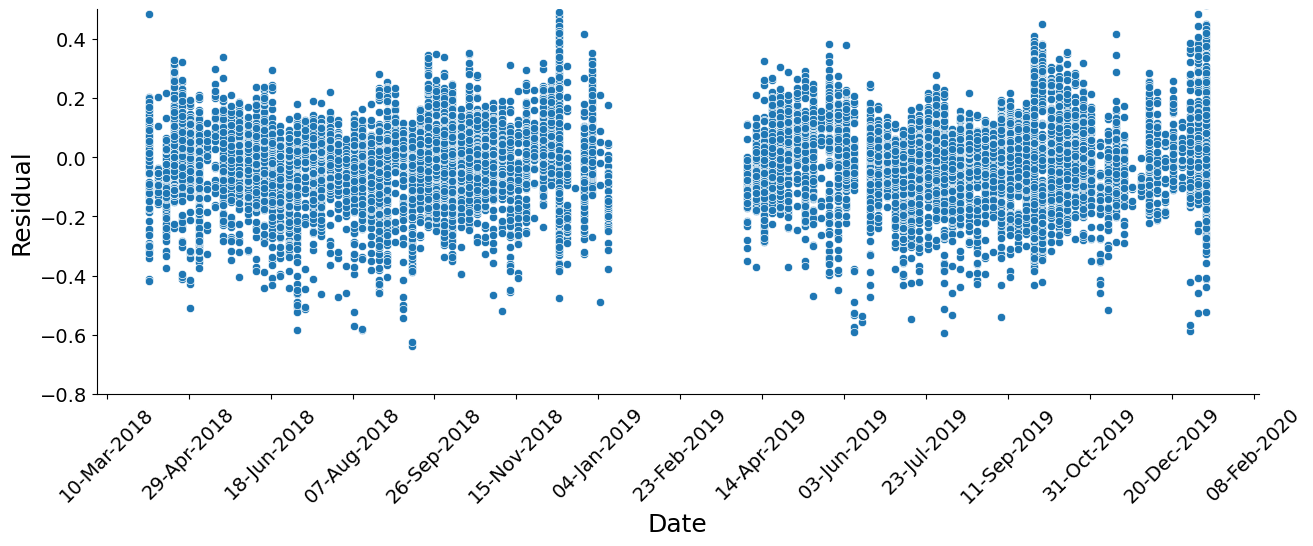

In [172]:
# Train
df_tr = df_tr.sort_values('date')

fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=df_tr, x='date2', y='res')
plt.ylabel('Residual', size=18)
plt.xlabel('Date', size=18)
sns.despine(top=True, right=True)
plt.ylim(-0.8, 0.5)

loc = plticker.MultipleLocator(base=50) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xticks(rotation=45)

# Plot dates as year-month
date_form = DateFormatter("%d-%b-%Y")
ax.xaxis.set_major_formatter(date_form)

plt.show()

# For nofilter: check cloud free label dates in the test set

In [112]:
def get_label_date_cloudfree(split, batch_size, n_batches, sample_type, exp):
    
    metadata_path = f'pixel_data/nofilter/{split}/'
    all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])
    all_loc_dates = []

    for f in all_loc_dates_files:
        with open(metadata_path+f, 'rb') as f :
            all_loc_dates += pickle.load(f)
    n_rep = 4000/len(all_loc_dates)
    
    
    
    cloudfree_date = list()
    ndvi_val = list()
    cp_vals = list()
    
    for batch_nbr in range(n_batches):
        
        # Load a batch here
        img, label = load_batch(batch_size=batch_size, batch_nbr=batch_nbr, sample_type=sample_type, split=split, exp=exp, n_timesteps_out=1)
        
        label_ndvi = label[:,:,15,:,:].squeeze(0).squeeze(0).squeeze(1).squeeze(1).squeeze(1).cpu().detach().numpy()
        pred_ndvi = pred[:,:,0].cpu().detach().numpy()

        # still predict both, but dont use cp_idx for masking clouds in loss
        cp_mask = label[:,:,0,:,:].squeeze(1).squeeze(1).squeeze(1)
        to_keep = 1 #NDVI only
        label = label[:,:,to_keep,:,:]
        
        cp_vals.append(cp_mask)
        
        for sample_id in range(label.size(0)):
            if cp_mask[sample_id]<0.01:
                filtered_idx = int(np.floor((batch_nbr*batch_size+sample_id)/n_rep))
                label_date = all_loc_dates[filtered_idx][3][:1]
                cloudfree_date.append(label_date)
                ndvi_val.append(label[sample_id, :, :, :])
        
        
    return cloudfree_date, ndvi_val, cp_vals

In [113]:
split = 'test'
batch_size = 40
n_batches = 42
sample_type = 'pixel_data'
exp = 'nofilter'

cloudfree_date, ndvi_val, cp_vals = get_label_date_cloudfree(split, batch_size, n_batches, sample_type, exp)

In [116]:
cp_vals = th.cat(cp_vals, axis=0)

In [119]:
cp_vals[cp_vals<0.01]

tensor([ 8.4625e-03,  6.5223e-03,  9.5571e-03,  8.3319e-03,  9.7513e-03,
         9.1823e-03,  6.9208e-03,  6.4439e-03,  8.6068e-03,  6.9869e-03,
         9.0908e-03,  9.6814e-03,  8.7063e-03,  9.6992e-03,  9.7279e-03,
         7.0654e-03,  8.3521e-03,  8.9462e-03,  6.5789e-03,  7.7448e-03,
         8.0829e-03,  8.5864e-03,  8.8182e-03,  5.4455e-03,  7.6848e-03,
        -5.5237e-06,  9.6573e-03,  9.8686e-03,  9.7690e-03,  9.2311e-03,
         8.4044e-03,  9.6305e-03,  8.1076e-03,  6.7213e-03,  8.4414e-03,
         5.7675e-03,  8.6428e-03,  7.9575e-03,  8.8530e-03,  2.9318e-03,
         6.5955e-03,  5.7042e-03,  6.1954e-03,  7.7972e-03,  6.9506e-03,
         7.2216e-03,  5.2788e-03,  6.2023e-03,  8.1381e-03,  6.3384e-03,
         6.3684e-03,  6.9262e-03,  5.5960e-03,  6.7412e-03,  7.7040e-03,
         7.3915e-03,  7.0584e-03,  7.2152e-03,  6.9997e-03,  6.8245e-03,
         7.8382e-03,  7.4173e-03,  7.1449e-03,  7.9798e-03,  6.5639e-03,
         9.6459e-03,  8.8027e-03,  6.9186e-03,  9.1

# Compare cleaned vs no filter data

In [15]:
batch = 0
batch_size = 40 
split = 'test2'
n_samples_split = 4000

In [16]:
metadata_path = f'pixel_data/nofilter/{split}/'

# Get date/range of pred
all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])
full_date_range_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('full_date_range')])

all_loc_dates = []

for f in all_loc_dates_files:
    with open(metadata_path+f, 'rb') as f :
        all_loc_dates += pickle.load(f)
        
full_date_range = []

for f in full_date_range_files:
    with open(metadata_path+f, 'rb') as f :
        full_date_range += pickle.load(f)
        
n_rep = n_samples_split/len(all_loc_dates)
idx_start = int(np.floor((batch_size*batch)/n_rep))
idx_last = int(np.floor((batch_size*batch + batch_size)/n_rep))
        
start_date_pred = all_loc_dates[idx_start][3]
end_date_pred = all_loc_dates[idx_last][3]

ZeroDivisionError: division by zero

In [39]:
all_loc_dates[idx_start][1]

['2020-05-04',
 '2020-05-14',
 '2020-05-24',
 '2020-06-03',
 '2020-06-13',
 '2020-06-23',
 '2020-07-03',
 '2020-07-13',
 '2020-07-23']

In [40]:
#img_raw, label_raw = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp='nofilter', n_timesteps_out=1)
#img_clean, label_clean = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp='clean', n_timesteps_out=1)
#img_cleanupd, label_cleanupd = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp='clean_update', n_timesteps_out=1)
#img_cleanupd2, label_cleanupd2 = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp='clean_update2', n_timesteps_out=1)
#img_cleanreg, label_cleanreg = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp='clean_region', n_timesteps_out=1)
#img_filt, label_filt = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp='filtered', n_timesteps_out=1)
img_filtclean, label_filtclean = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp='filtered_clean', n_timesteps_out=1)

In [32]:
img_raw[0,:,15,:,:]

tensor([[[0.2722]],

        [[0.3396]],

        [[0.2776]],

        [[0.2707]],

        [[0.2573]],

        [[0.2426]],

        [[0.2601]],

        [[0.2929]],

        [[0.2647]]])

In [41]:
#ndvi_raw = th.cat([img_raw[:,:,15,:,:], label_raw[:,:,15,:,:]], axis=1)
#ndvi_clean = th.cat([img_clean[:,:,15,:,:], label_clean[:,:,15,:,:]], axis=1)
#ndvi_upd = th.cat([img_cleanupd[:,:,15,:,:], label_cleanupd[:,:,15,:,:]], axis=1)
#ndvi_upd2 = th.cat([img_cleanupd2[:,:,15,:,:], label_cleanupd2[:,:,15,:,:]], axis=1)
#cloud_raw = th.cat([img_raw[:,:,14,:,:], label_raw[:,:,14,:,:]], axis=1)
#ndvi_reg = th.cat([img_cleanreg[:,:,15,:,:], label_cleanreg[:,:,15,:,:]], axis=1)
#ndvi_filt = th.cat([img_filt[:,:,15,:,:], label_filt[:,:,15,:,:]], axis=1)
ndvi_filtclean = th.cat([img_filtclean[:,:,15,:,:], label_filtclean[:,:,15,:,:]], axis=1)

#cloud =  th.cat([img_raw[:,:,14,:,:], label_raw[:,:,14,:,:]], axis=1)

In [42]:
split_path = f'/dccstor/cimf/drought_impact/pixel_based/pixel_data/filtered/{split}/'
with open(split_path+'cloud_free_samples.pkl', 'rb') as f:
    cloud_free_samples = pickle.load(f)

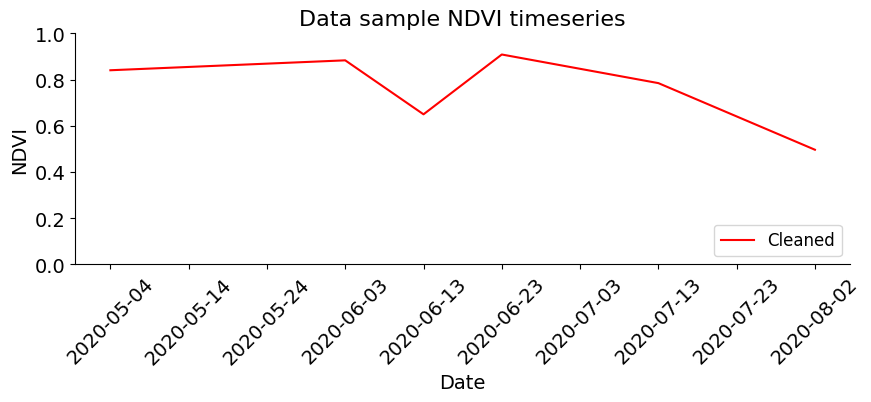

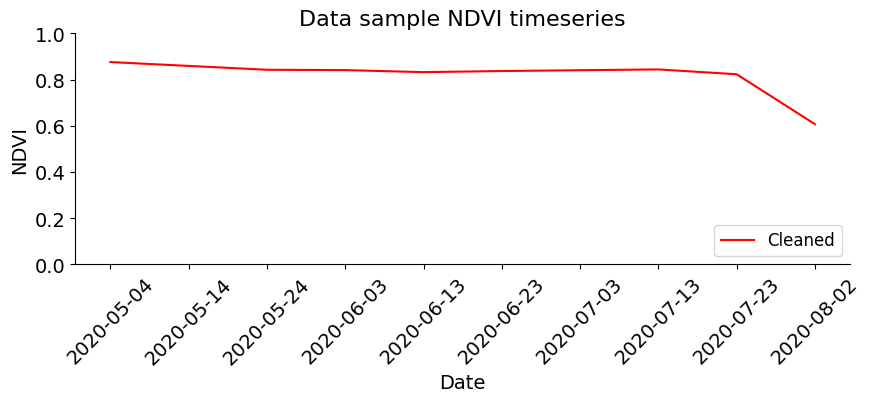

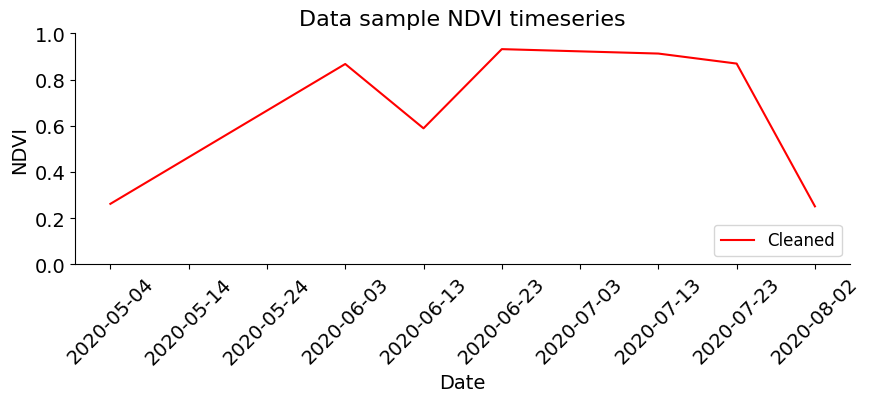

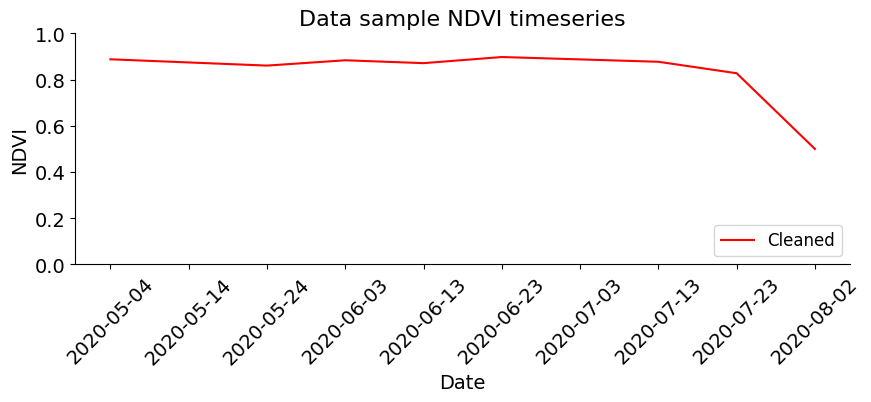

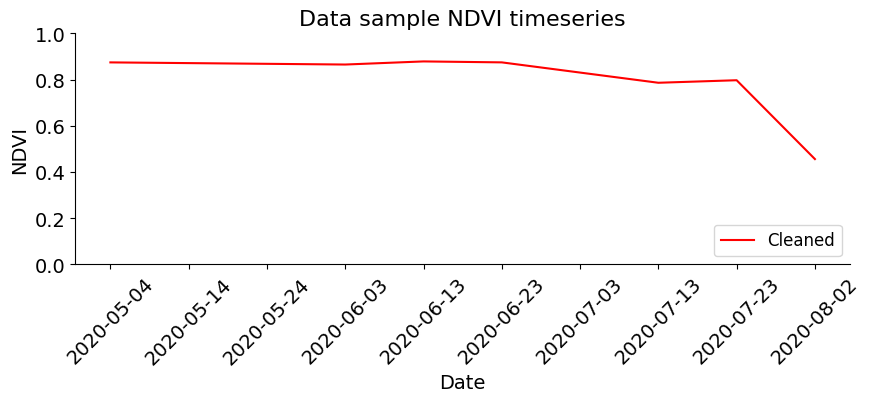

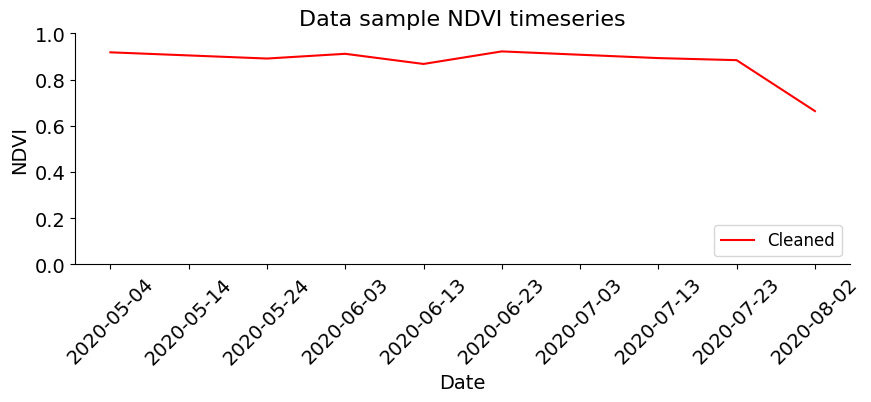

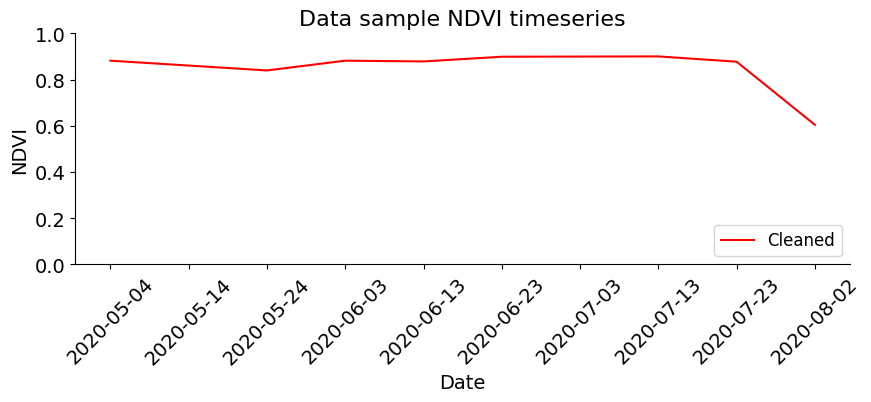

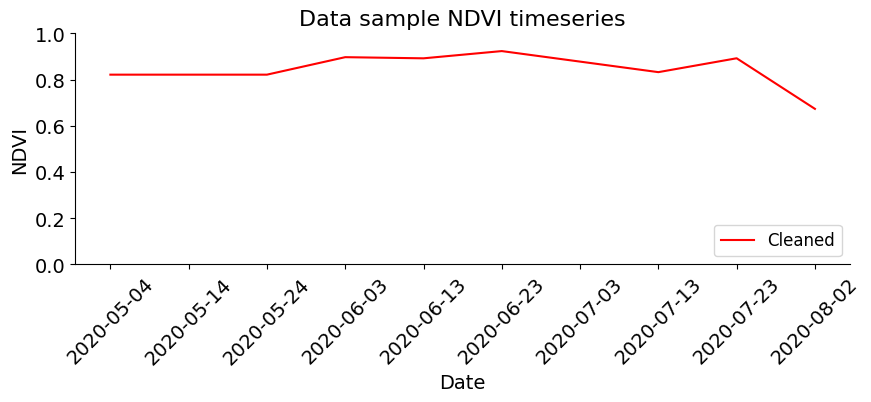

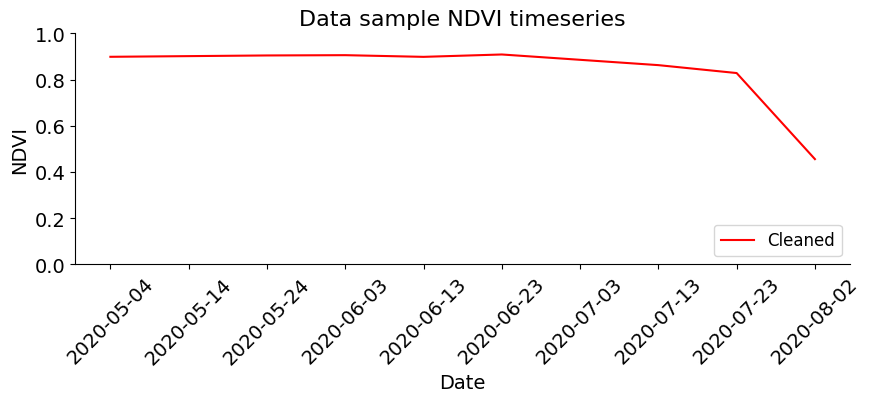

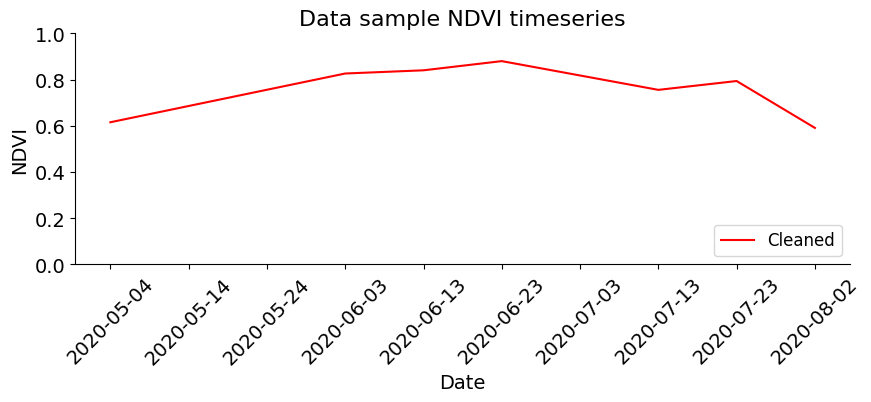

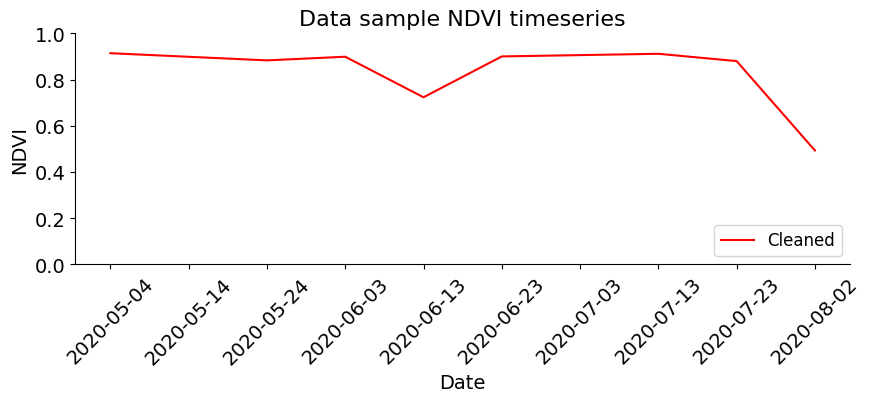

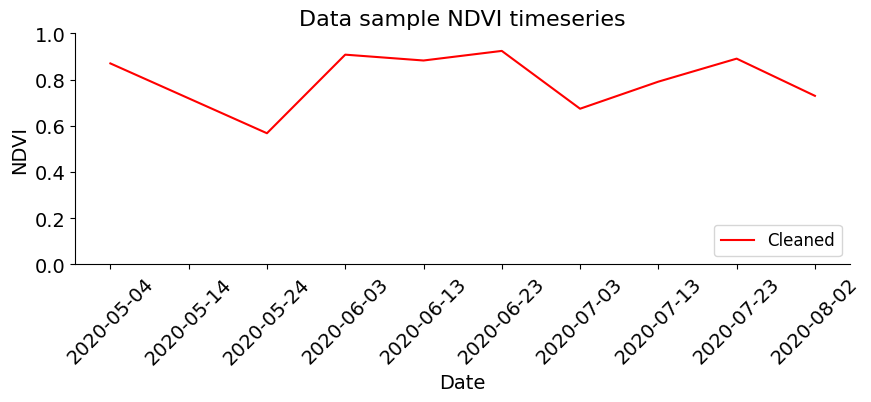

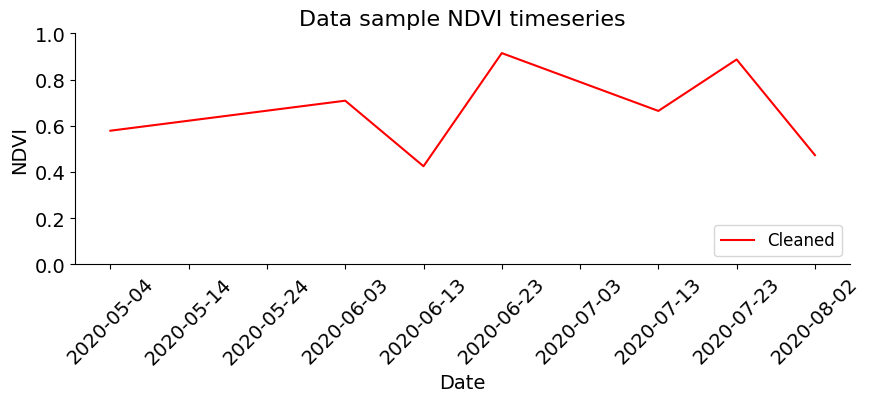

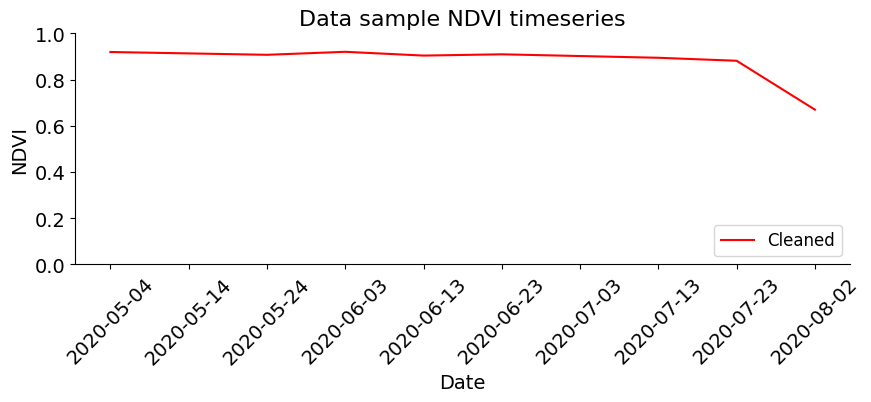

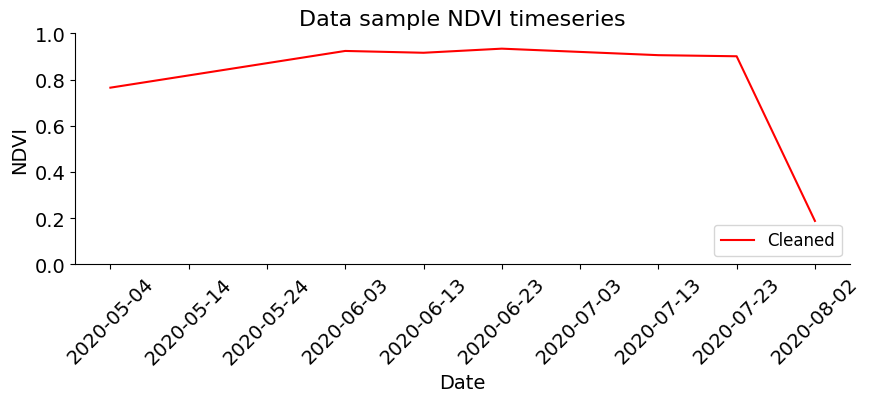

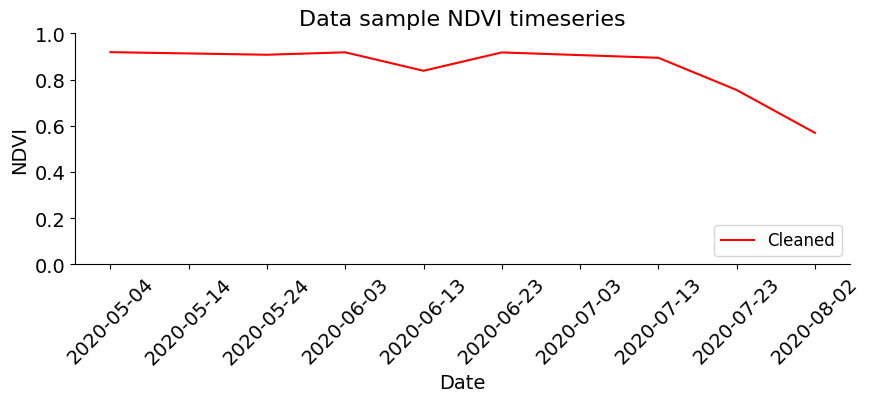

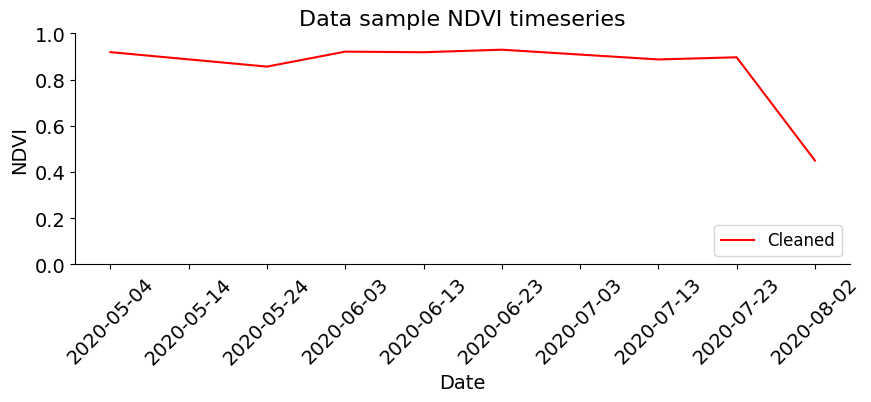

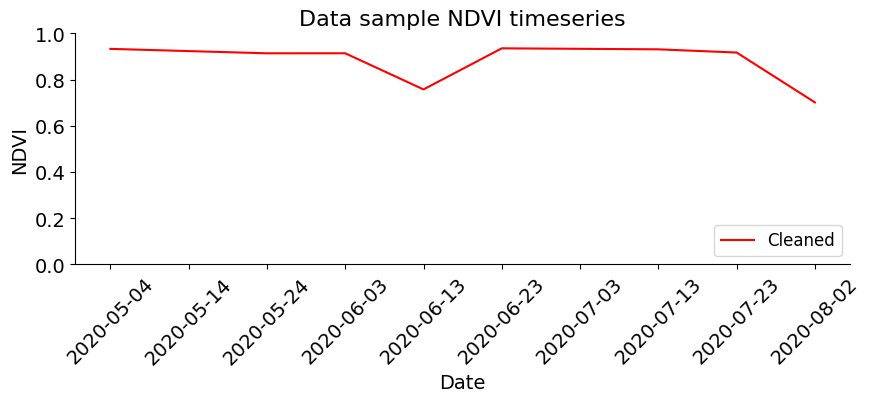

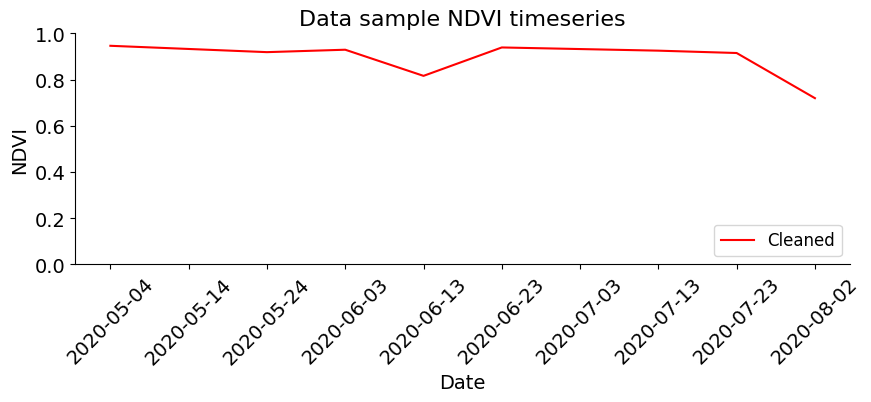

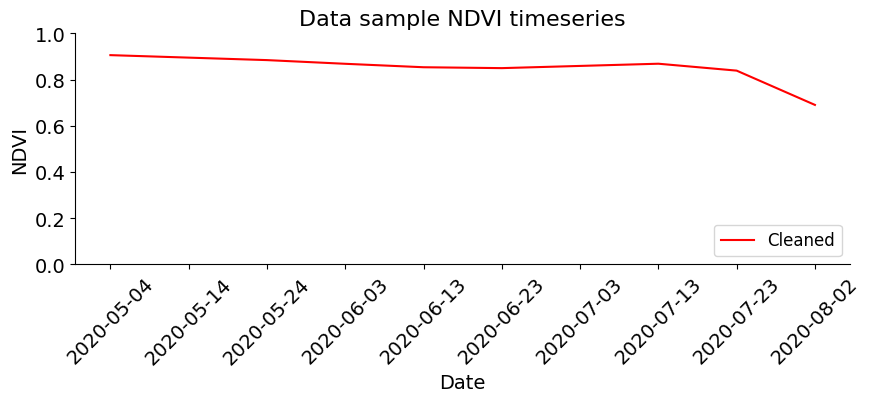

In [43]:
# Plot timeseries of a single pixel (CP)

for sample_id in range(20):
    #raw = ndvi_raw[sample_id, :, :, :].squeeze(1).squeeze(1)
    #clean = ndvi_clean[sample_id, :, :, :].squeeze(1).squeeze(1)
    #upd = ndvi_upd[sample_id, :, :, :].squeeze(1).squeeze(1)
    #upd2 = ndvi_upd2[sample_id, :, :, :].squeeze(1).squeeze(1)
    #reg = ndvi_reg[sample_id, :, :, :].squeeze(1).squeeze(1)
    #filt = ndvi_filt[sample_id, :, :, :].squeeze(1).squeeze(1)
    cleanfilt = ndvi_filtclean[sample_id, :, :, :].squeeze(1).squeeze(1)
    dates = all_loc_dates[idx_start][1] + all_loc_dates[idx_start][3][:1]
    
    #filtered_idx = int(np.floor(cloud_free_samples[batch*batch_size+sample_id]/n_rep))
    #dates = all_loc_dates[filtered_idx][1] + all_loc_dates[filtered_idx][3][:1]
    
    #cp = cloud[sample_id, :, :, :].squeeze(1).squeeze(1)

    fig, ax = plt.subplots(1,1,figsize=(10,3))
    plt.title('Data sample NDVI timeseries', fontsize=16)
    #sns.lineplot(ax=ax, y=clean, x=dates,label='clean')
    #sns.lineplot(ax=ax, y=raw, x=dates,label='raw')
    #sns.lineplot(ax=ax, y=upd, x=dates,label='upd')
    #sns.lineplot(ax=ax, y=reg, x=dates,label='reg')
    #sns.lineplot(ax=ax, y=upd2, x=dates,label='upd2')
    #sns.lineplot(ax=ax, y=cp, x=dates,label='cp')
    #sns.scatterplot(ax=ax, y=cleanfilt, x=dates, color='red')
    sns.lineplot(ax=ax, y=cleanfilt, x=dates,label='Cleaned', color='red')
    #sns.lineplot(ax=ax, y=filt, x=dates,label='Raw', color='blue')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('NDVI', fontsize=14)
    plt.ylim(0,1)
    sns.despine(top=True, right=True)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='lower right', fontsize=12)

# Compare corrected bands

In [ ]:
# Compare NDVI curves
ndvi_valais = np.load(f'corrected_bands/correct_ndvi_5_valais.npy') 
ndvi_vaud = np.load(f'corrected_bands/correct_ndvi_5_vaud.npy') 
ndvi_jura = np.load(f'corrected_bands/correct_ndvi_5_jura.npy') 
ndvi_schaff = np.load(f'corrected_bands/correct_ndvi_5_schaff.npy') 

In [ ]:
import pandas as pd

# Convert list timestamp to ordered list ints
date_range = pd.date_range(start='2015-08-01', end='2021-12-31', freq='D', inclusive="both")
x_new = np.arange(0,len(date_range), 1) # to interpolate/extrapolate
    

fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.lineplot(ax=ax,y=ndvi_valais, x=x_new, label='valais')
sns.lineplot(ax=ax,y=ndvi_vaud, x=x_new, label='vaud')
sns.lineplot(ax=ax,y=ndvi_jura, x=x_new, label='jura')
sns.lineplot(ax=ax,y=ndvi_schaff, x=x_new, label='schaff')
sns.set_style("ticks")
plt.title('Median NDVI timeseries')
plt.ylabel("NDVI")
plt.ylim(0,1.1)

# Plot predictions spatially

### Set params

In [14]:
exp =   'filtered_clean' #'nofilter' #
batch = 0
batch_size = 40 
epoch = 0
n_batches = 559
split_size= 40000 #
sample_type = 'pixel_data'
setup =  'final10_filter_26-02-2023_0.0001041_2_32' #'all_filter_19-02-2023_0.0001041_2_32'#'sen_filter_20-02-2023_0.0001041_2_32' # #'simple_cp_17-02-2023_0.00129_2_96' # 'simple_cleanfilt_20-02-2023_0.00038_1_120' #
split = 'train'

## Metadata
For train set there are 1000 called samples missing (2018 p2.9). Just skip these samples for now

In [16]:
metadata_path = f'pixel_data/nofilter/{split}/'
split_path = f'/dccstor/cimf/drought_impact/pixel_based/pixel_data/filtered/{split}/'
with open(split_path+'cloud_free_samples.pkl', 'rb') as f:
    cloud_free_samples = pickle.load(f)
    
# Get date/range of pred
all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])
full_date_range_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('full_date_range')])

all_loc_dates = []

for f in all_loc_dates_files:
    with open(metadata_path+f, 'rb') as f :
        all_loc_dates += pickle.load(f)
        
full_date_range = []

for f in full_date_range_files:
    with open(metadata_path+f, 'rb') as f :
        full_date_range += pickle.load(f)
        
n_rep = split_size/len(all_loc_dates)
idx_start = int(np.floor((batch_size*batch)/n_rep))
idx_last = int(np.floor((batch_size*batch + batch_size)/n_rep))

# Geolocation
called_samples_file = sorted([f for f in os.listdir(metadata_path) if f.startswith('called_samples')])
called_samples = []

for f in called_samples_file:
    called_samples += th.load(metadata_path+f)

## Get all preds

In [17]:
df_pred_coords = pd.DataFrame()

for batch in range(n_batches):
    pred_path = f'pixel_data/{exp}/preds/{split}/{setup}_data_cube_b{batch}.pt'
    pred = th.load(pred_path)
    pred_ndvi = pred[:,:,0].detach()
    
    img, label = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp=exp, n_timesteps_out=1)
    
    # Get coord and date of pred
    for sample_id in range(batch_size):

        ndvi_label = label[sample_id, :, 15, :, :].squeeze(1).squeeze(1).numpy()
        ndvi_pred = pred_ndvi[sample_id].detach().cpu()

        # If data filtered
        filtered_idx = int(np.floor(cloud_free_samples[batch*batch_size+sample_id]/n_rep))
        dates = all_loc_dates[filtered_idx][3][:1] #is a list
        
        if 'train' not in split:
            coords = called_samples[cloud_free_samples[batch*batch_size+sample_id]][0][1:3].detach().numpy() #array
        else:
            # The samples between 19k and 20k are missing
            idx_called = cloud_free_samples[batch*batch_size+sample_id]
            if idx_called >= 20000:
                idx_called -= 1000
            coords = called_samples[idx_called][0][1:3].detach().numpy() #array
            
        context_dates = all_loc_dates[filtered_idx][1]
        context_ndvi = img[sample_id, :, 15, :, :].squeeze(1).squeeze(1).numpy()
        
        df_pred_coords = pd.concat([df_pred_coords, pd.DataFrame({"date":dates, "context_dates": [context_dates], "lat": [coords[1]], "lon": [coords[0]],"pred":ndvi_pred, "label": ndvi_label, "context_ndvi":[context_ndvi]})], ignore_index=True)

In [18]:
# Make a geopandas
gdf = gpd.GeoDataFrame(df_pred_coords, geometry=gpd.points_from_xy(df_pred_coords.lon, df_pred_coords.lat))
gdf = gdf.set_crs('epsg:4326')
unique_dates = np.unique(gdf.date)
print(unique_dates)

['2018-04-05' '2018-04-10' '2018-04-15' '2018-04-20' '2018-04-25'
 '2018-04-30' '2018-05-05' '2018-05-10' '2018-05-15' '2018-05-20'
 '2018-05-25' '2018-05-30' '2018-06-04' '2018-06-09' '2018-06-14'
 '2018-06-19' '2018-06-24' '2018-06-29' '2018-07-04' '2018-07-09'
 '2018-07-14' '2018-07-19' '2018-07-24' '2018-07-29' '2018-08-03'
 '2018-08-08' '2018-08-13' '2018-08-18' '2018-08-23' '2018-08-28'
 '2018-09-02' '2018-09-07' '2018-09-12' '2018-09-17' '2018-09-22'
 '2018-09-27' '2018-10-02' '2018-10-07' '2018-10-12' '2018-10-17'
 '2018-10-22' '2018-10-27' '2018-11-01' '2018-11-06' '2018-11-11'
 '2018-11-16' '2018-11-21' '2018-11-26' '2018-12-01' '2018-12-06'
 '2018-12-11' '2018-12-16' '2018-12-21' '2018-12-26' '2018-12-31'
 '2019-01-05' '2019-01-10' '2019-04-05' '2019-04-10' '2019-04-15'
 '2019-04-20' '2019-04-25' '2019-04-30' '2019-05-05' '2019-05-10'
 '2019-05-15' '2019-05-20' '2019-05-25' '2019-05-30' '2019-06-04'
 '2019-06-09' '2019-06-14' '2019-06-19' '2019-06-24' '2019-06-29'
 '2019-07-

In [19]:
gdf['resid'] = gdf['label'] - gdf['pred']

In [20]:
# Check how many times same pixel represented
gdf['wkt'] = gdf['geometry'].to_wkt()
gdf.groupby('wkt').count().geometry.reset_index()#.sort_values('geoemetry', ascending=False)

wkt  geometry
0     POINT (7.142003 47.175117)         2
1      POINT (7.142007 46.94756)         2
2     POINT (7.142307 47.200738)         2
3       POINT (7.142313 47.2513)         4
4     POINT (7.142383 47.097313)         2
...                          ...       ...
9847   POINT (7.631431 47.28649)         3
9848   POINT (7.631466 46.96212)         3
9849  POINT (7.631472 47.293037)         3
9850  POINT (7.631487 47.291877)         2
9851   POINT (7.631515 46.94145)         4

[9852 rows x 2 columns]

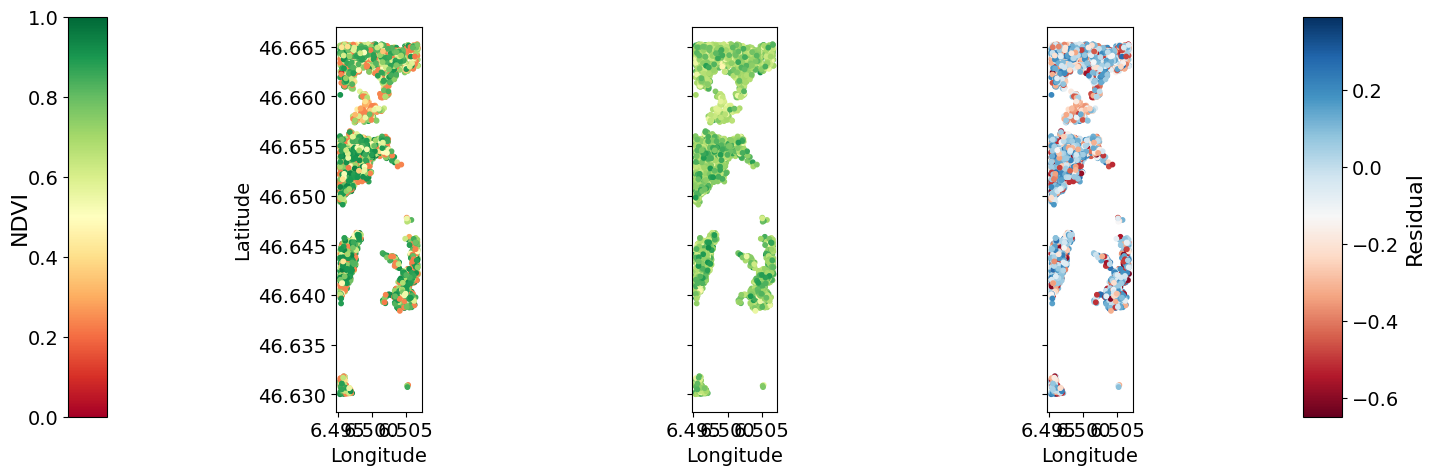

In [9]:
# Plot: ALL TIMES

fig, axs = plt.subplots(1,3,figsize=(13, 5), sharex=True, sharey=True)
#fig, axs = plt.subplots(1,2,figsize=(8, 5), sharex=True, sharey=True)

vmin = 0 #gdf.label.min()
vmax = gdf.label.max()

gdf.plot(ax=axs[0], column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=10) 
#axs[0].set_title(f'Label {unique_dates[0]} - {unique_dates[-1]}', pad=30)
#axs[0].set_title(f'Label')
axs[0].set_xlabel('Longitude', size=14)
axs[0].set_ylabel('Latitude', size=14)
axs[0].tick_params(axis='both', labelsize=14)
#cx.add_basemap(ax=axs[0], crs=gdf.crs.to_string())

gdf.plot(ax=axs[1], column='pred', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=10) 
#axs[1].set_title(f'Prediction {unique_dates[0]} - {unique_dates[-1]}', pad=30)
#axs[1].set_title('Prediction')
axs[1].set_xlabel('Longitude', size=14)
#axs[1].set_ylabel('Latitude', size=14)
axs[1].tick_params(axis='both', labelsize=14)
#cx.add_basemap(ax=axs[1], crs=gdf.crs.to_string())

# Add colorbar
fig = axs[1].get_figure()
cax = fig.add_axes([0, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("NDVI", size=16, labelpad=-70)
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.set_ticks_position('left')

vmin_resid = gdf.resid.min()
vmax_resid = gdf.resid.max()
gdf.plot(ax=axs[2], column='resid', cmap='RdBu', vmin=vmin_resid, vmax=vmax_resid, markersize=10) 
#axs.set_title(f'Residual {unique_dates[0]} - {unique_dates[-1]}')
#axs.set_title('Residual')
axs[2].set_xlabel('Longitude', size=14)
#axs.set_ylabel('Latitude', size=14)
axs[2].tick_params(axis='both', labelsize=14)
#cx.add_basemap(ax=axs[2], crs=gdf.crs.to_string())

# Add colorbar
fig = axs[2].get_figure()
cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin_resid, vmax=vmax_resid))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Residual", size=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

In [21]:
# FIND TIMESERIES THAT ARE LOW ALL THE TIME --> how are residuals?
gdf["mean_context"] = gdf["context_ndvi"].apply(lambda x: np.mean(x))
gdf[gdf.mean_context<0.5].resid.mean()

-0.02280563

In [22]:
# FIND TIMESERIES THAT ARE LOW IN SUMMER --> how are residuals?
gdf["month"] = gdf["date"].apply(lambda x: int(x.split('-')[1]))
gdf["year"] = gdf["date"].apply(lambda x: int(x.split('-')[0]))
gdf["last_context"] = gdf["context_ndvi"].apply(lambda x: x[0])
gdf[(gdf.month>6) & (gdf.month<10) & (gdf.mean_context<0.5)].resid.mean()

-0.16029435

In [75]:
#gdf[(gdf.month>6) & (gdf.month<10)].mean_context.mean()
gdf.mean_context.mean()

0.81214905

In [91]:
# FIND POINTS THAT HAVE ABRUPT DROP IN LABEL (CLEANING PROBLEM) --> are residuals high for those points?
gdf[(gdf.label<0.25) & (gdf.mean_context>0.5)].resid.mean()

-0.49609396

In [31]:
# Val set
print(gdf[gdf.wkt=='POINT (7.369289 47.327496)'].reset_index(drop=True).context_ndvi[0])
print(gdf[gdf.wkt=='POINT (7.369289 47.327496)'].reset_index(drop=True).label[0])

print(gdf[gdf.wkt=='POINT (7.373586 47.23688)'].reset_index(drop=True).context_ndvi[0])
print(gdf[gdf.wkt=='POINT (7.373586 47.23688)'].reset_index(drop=True).label[0])

print(gdf[gdf.wkt=='POINT (7.401854 47.303297)'].reset_index(drop=True).context_ndvi[0])
print(gdf[gdf.wkt=='POINT (7.401854 47.303297)'].reset_index(drop=True).label[0])

KeyError: 0

In [92]:
# FIND POINTS WITH HIGH RESIDUALS --> what is their mean context and label?
print(gdf[np.abs(gdf.resid)>0.2].mean_context.mean())
print(gdf[np.abs(gdf.resid)>0.2].label.mean())

0.6256154
0.51696026


In [70]:
# FIND POINTS WITH HIGH RESIDUALS --> what is their mean last context day (time t)
gdf["last_context"] = gdf["context_ndvi"].apply(lambda x: x[0])
print(gdf[np.abs(gdf.resid)>0.2].last_context.mean())
print(gdf[np.abs(gdf.resid)>0.2].label.mean())

0.8007604
0.37380046


In [52]:
# FIND POINTS WITH LOW RESIDUALS --> what is their mean last context day (time t)
print(gdf[np.abs(gdf.resid)<0.2].last_context.mean())
print(gdf[np.abs(gdf.resid)<0.2].label.mean())

0.69667155
0.75865155


#### Plot average timeseries and residuals for different conditions

In [169]:
# Val mean context high 
#gdf_tmp = gdf[(gdf.last_context - gdf.label < 0.1) & (gdf.mean_context > 0.75)]
#gdf_tmp2 = gdf[(gdf.last_context - gdf.label < 0.1) & (gdf.mean_context < 0.75)]

# Vaud: compare 2018 and 2019
gdf_tmp = gdf[(gdf.year==2018) & (gdf.month.isin([8])) & (gdf.last_context - gdf.label < 0.1)]
gdf_tmp2 = gdf[(gdf.year==2019)  & (gdf.month.isin([8])) & (gdf.last_context - gdf.label < 0.1)]

In [136]:
df_dates = pd.DataFrame(gdf_tmp["context_ndvi"].to_list(), columns=['t-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 't'])
df_dates["t+1"] = gdf_tmp["label"].tolist()
df_dates = df_dates.stack().reset_index()
df_dates.columns = ['index', 'timestep', 'NDVI']

df_dates2 = pd.DataFrame(gdf_tmp2["context_ndvi"].to_list(), columns=['t-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1', 't'])
df_dates2["t+1"] = gdf_tmp2["label"].tolist()
df_dates2 = df_dates2.stack().reset_index()
df_dates2.columns = ['index', 'timestep', 'NDVI']

In [171]:
print(gdf_tmp.mean_context.median())
print(gdf_tmp2.mean_context.median())
print(gdf_tmp.resid.mean())
print(gdf_tmp2.resid.mean())

0.85943407
0.8121127
0.10335361
0.10310005


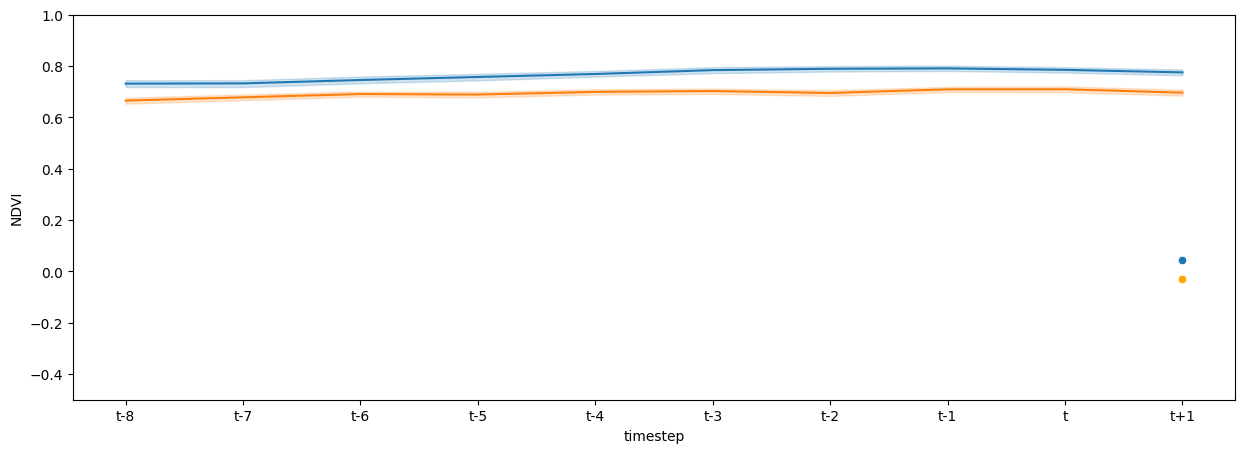

In [126]:
# Vaud validation set 
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.lineplot(x='timestep', y='NDVI', data=df_dates)
sns.scatterplot(x=['t+1'], y=gdf_tmp.resid.mean())
sns.lineplot(x='timestep', y='NDVI', data=df_dates2)
sns.scatterplot(x=['t+1'], y=gdf_tmp2.resid.mean(), color='orange')
#plt.xticks(range(len(x_labels)), x_labels)
plt.ylim(-0.5,1)
plt.show()

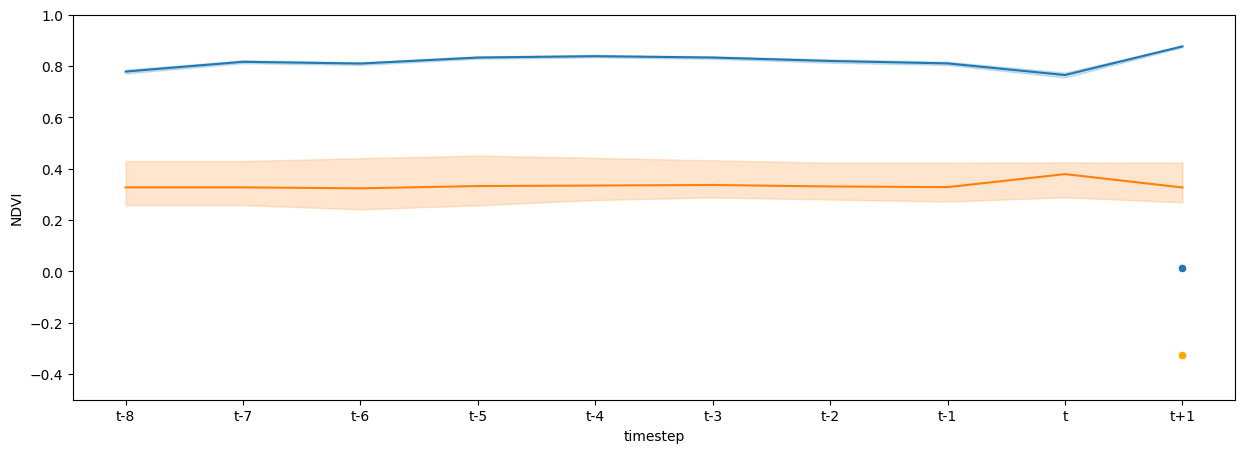

In [72]:
# Jura valiaditon set 
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.lineplot(x='timestep', y='NDVI', data=df_dates)
sns.scatterplot(x=['t+1'], y=gdf_tmp.resid.mean())
sns.lineplot(x='timestep', y='NDVI', data=df_dates2)
sns.scatterplot(x=['t+1'], y=gdf_tmp2.resid.mean(), color='orange')
#plt.xticks(range(len(x_labels)), x_labels)
plt.ylim(-0.5,1)
plt.show()

### Test set filtered for abnormal label dropping

In [70]:
# Filter out the abrutp label drops
gdf = gdf[gdf.last_context - gdf.label < 0.1]

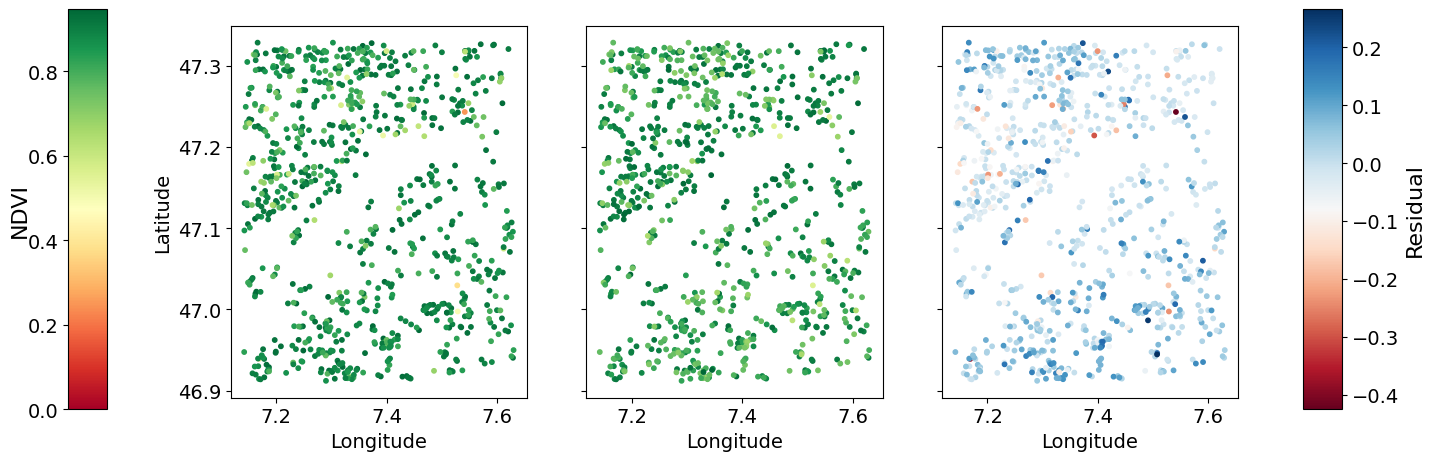

In [71]:
# Plot: ALL TIMES

fig, axs = plt.subplots(1,3,figsize=(13, 5), sharex=True, sharey=True)
#fig, axs = plt.subplots(1,2,figsize=(8, 5), sharex=True, sharey=True)

vmin = 0 #gdf.label.min()
vmax = gdf.label.max()

gdf.plot(ax=axs[0], column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=10) 
#axs[0].set_title(f'Label {unique_dates[0]} - {unique_dates[-1]}', pad=30)
#axs[0].set_title(f'Label')
axs[0].set_xlabel('Longitude', size=14)
axs[0].set_ylabel('Latitude', size=14)
axs[0].tick_params(axis='both', labelsize=14)
#cx.add_basemap(ax=axs[0], crs=gdf.crs.to_string())

gdf.plot(ax=axs[1], column='pred', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=10) 
#axs[1].set_title(f'Prediction {unique_dates[0]} - {unique_dates[-1]}', pad=30)
#axs[1].set_title('Prediction')
axs[1].set_xlabel('Longitude', size=14)
#axs[1].set_ylabel('Latitude', size=14)
axs[1].tick_params(axis='both', labelsize=14)
#cx.add_basemap(ax=axs[1], crs=gdf.crs.to_string())

# Add colorbar
fig = axs[1].get_figure()
cax = fig.add_axes([0, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("NDVI", size=16, labelpad=-70)
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.set_ticks_position('left')

vmin_resid = gdf.resid.min()
vmax_resid = gdf.resid.max()
gdf.plot(ax=axs[2], column='resid', cmap='RdBu', vmin=vmin_resid, vmax=vmax_resid, markersize=10) 
#axs.set_title(f'Residual {unique_dates[0]} - {unique_dates[-1]}')
#axs.set_title('Residual')
axs[2].set_xlabel('Longitude', size=14)
#axs.set_ylabel('Latitude', size=14)
axs[2].tick_params(axis='both', labelsize=14)
#cx.add_basemap(ax=axs[2], crs=gdf.crs.to_string())

# Add colorbar
fig = axs[2].get_figure()
cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin_resid, vmax=vmax_resid))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Residual", size=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

### Val set filtered for abnormal label dropping

In [80]:
# Filter out the abrutp label drops
gdf = gdf[gdf.last_context - gdf.label < 0.1]

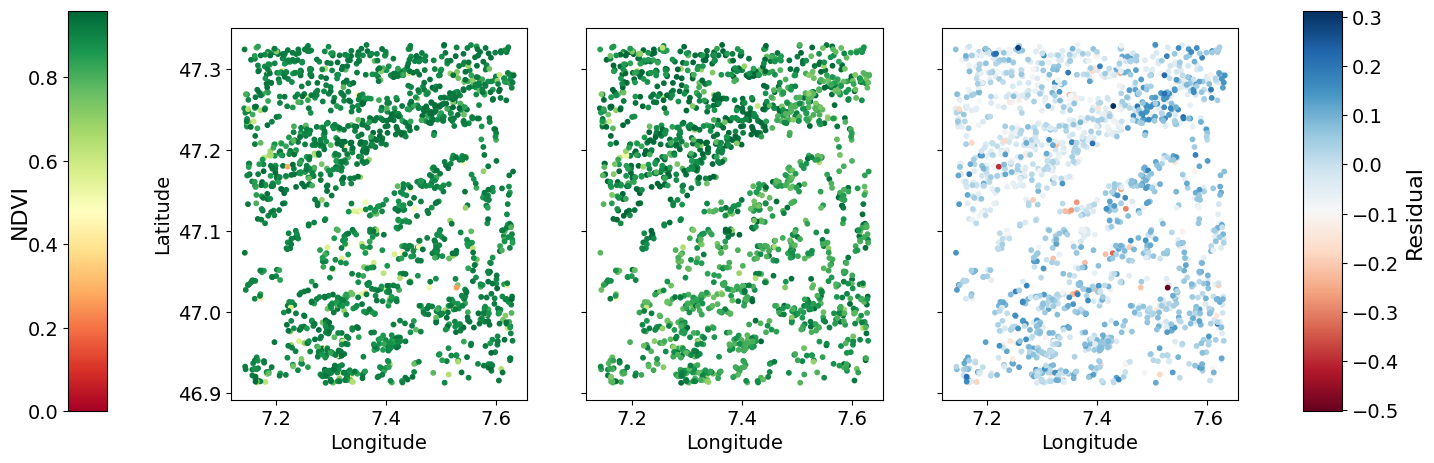

In [81]:
# Plot: ALL TIMES

fig, axs = plt.subplots(1,3,figsize=(13, 5), sharex=True, sharey=True)
#fig, axs = plt.subplots(1,2,figsize=(8, 5), sharex=True, sharey=True)

vmin = 0 #gdf.label.min()
vmax = gdf.label.max()

gdf.plot(ax=axs[0], column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=10) 
#axs[0].set_title(f'Label {unique_dates[0]} - {unique_dates[-1]}', pad=30)
#axs[0].set_title(f'Label')
axs[0].set_xlabel('Longitude', size=14)
axs[0].set_ylabel('Latitude', size=14)
axs[0].tick_params(axis='both', labelsize=14)
#cx.add_basemap(ax=axs[0], crs=gdf.crs.to_string())

gdf.plot(ax=axs[1], column='pred', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=10) 
#axs[1].set_title(f'Prediction {unique_dates[0]} - {unique_dates[-1]}', pad=30)
#axs[1].set_title('Prediction')
axs[1].set_xlabel('Longitude', size=14)
#axs[1].set_ylabel('Latitude', size=14)
axs[1].tick_params(axis='both', labelsize=14)
#cx.add_basemap(ax=axs[1], crs=gdf.crs.to_string())

# Add colorbar
fig = axs[1].get_figure()
cax = fig.add_axes([0, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("NDVI", size=16, labelpad=-70)
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.set_ticks_position('left')

vmin_resid = gdf.resid.min()
vmax_resid = gdf.resid.max()
gdf.plot(ax=axs[2], column='resid', cmap='RdBu', vmin=vmin_resid, vmax=vmax_resid, markersize=10) 
#axs.set_title(f'Residual {unique_dates[0]} - {unique_dates[-1]}')
#axs.set_title('Residual')
axs[2].set_xlabel('Longitude', size=14)
#axs.set_ylabel('Latitude', size=14)
axs[2].tick_params(axis='both', labelsize=14)
#cx.add_basemap(ax=axs[2], crs=gdf.crs.to_string())

# Add colorbar
fig = axs[2].get_figure()
cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin_resid, vmax=vmax_resid))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Residual", size=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

### Vaud

In [41]:
# Filter out the abrutp label drops
gdf = gdf[gdf.last_context - gdf.label < 0.1]

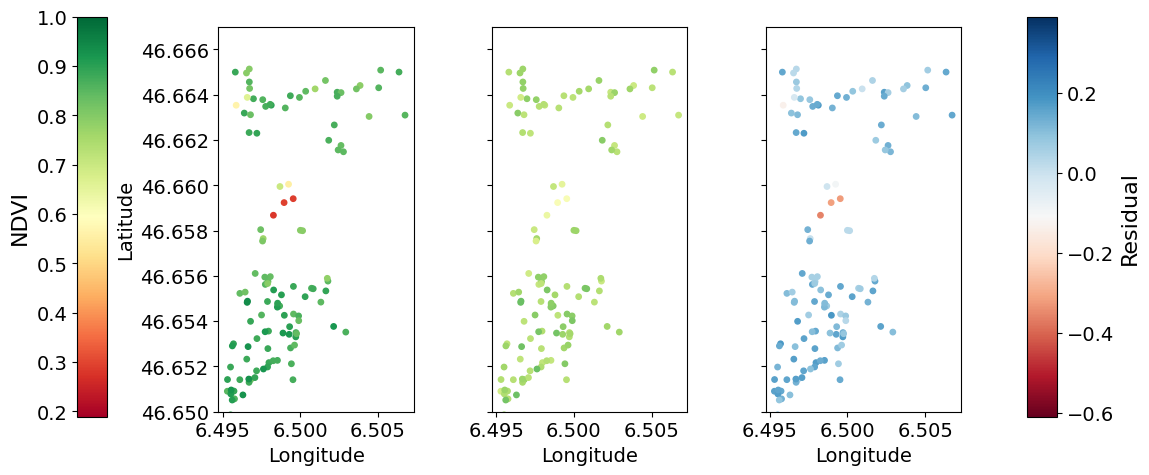

In [58]:
# Plot: specific date or range of dates

dates = ['2018-08-03', '2018-08-08','2018-08-18', '2018-08-23', '2018-08-28', '2018-09-02', '2018-09-07', '2018-09-12', '2018-09-17', '2018-09-22', '2018-09-27']
#['2021-08-07', '2021-08-12',  '2021-08-17', '2021-08-22', '2021-08-27', '2021-09-01', '2021-09-11', '2021-09-21']
#['2019-08-03', '2019-08-08', '2019-08-13', '2019-08-18', '2019-08-28', '2019-09-07', '2019-09-12', '2019-09-17', '2019-09-22', '2019-09-27']
#

# VAUD
#['2020-08-02','2020-08-07','2020-08-12', '2020-08-17', '2020-08-27', '2020-09-01', '2020-09-11', '2020-09-16', '2020-09-21', '2020-09-26']
#
#
# Or filter for certain dates
#dates = [x for x in unique_dates if x.split('-')[1] in ['06','07','08','09']] #summer months


date_title = f'{dates[0]} - {dates[-1]} '

fig, axs = plt.subplots(1,3,figsize=(10, 5), sharex=True, sharey=True)

vmin = gdf.label.min()
vmax = gdf.label.max()

gdf[gdf.date.isin(dates)].plot(ax=axs[0], column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=15) 
#axs[0].set_title(f'Label {date_title}')
axs[0].set_ylim(46.650, 46.667)
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_xlabel('Longitude', size=14)
axs[0].set_ylabel('Latitude', size=14)
#cx.add_basemap(ax=axs[0], crs=gdf.crs.to_string())

gdf[gdf.date.isin(dates)].plot(ax=axs[1], column='pred', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=15) 
#axs[1].set_title(f'Prediction {date_title}')
axs[1].set_ylim(46.650, 46.667)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_xlabel('Longitude', size=14)
#cx.add_basemap(ax=axs[1], crs=gdf.crs.to_string())


vmin_resid = gdf.resid.min()
vmax_resid = gdf.resid.max()
gdf[gdf.date.isin(dates)].plot(ax=axs[2], column='resid', cmap='RdBu', vmin=vmin_resid, vmax=vmax_resid, markersize=15) 
#axs[2].set_title(f'Residual {date_title}')
axs[2].set_ylim(46.650, 46.667)
axs[2].tick_params(axis='both', labelsize=14)
axs[2].set_xlabel('Longitude', size=14)
#cx.add_basemap(ax=axs[2], crs=gdf.crs.to_string())


# Add colorbar
fig = axs[1].get_figure()
cax = fig.add_axes([0, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("NDVI", size=16, labelpad=-70)
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.set_ticks_position('left')


# Add colorbar
fig = axs[2].get_figure()
cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin_resid, vmax=vmax_resid))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Residual", size=16)
cbar.ax.tick_params(labelsize=14)

plt.show()

In [16]:
gdf.geometry.bounds.maxy.max()

46.6652434832263

# Compare drought vs no drought distributions
- filter out data where label drops wrt to context
1. Compare Jura dvs Vaud drought
2. Compare Vaud drought vs Vaud no drought


### 1. Compare Jura vs Vaud

In [23]:
# Filter out when abrupt label drop happens
gdf_jura = gdf[gdf.last_context - gdf.label < 0.1]
# Get drought event (Sep 2018)
gdf_jura = gdf_jura[(gdf_jura.month==8) & (gdf_jura.year==2018)]

In [12]:
# Filter out when abrupt label drop happens
gdf_vaud = gdf[gdf.last_context - gdf.label < 0.1]
# Get drought event (Sep 2018)
gdf_vaud = gdf_vaud[(gdf_vaud.month==8) & (gdf_vaud.year==2018)]

In [13]:
# Filter out when abrupt label drop happens
gdf_none = gdf[gdf.last_context - gdf.label < 0.1]
# Get NO drought event (Sep 2019)
gdf_none = gdf_none[(gdf_none.month==8) & (gdf_none.year==2019)]

Text(149.47684250750535, 0.5, 'Latitude')

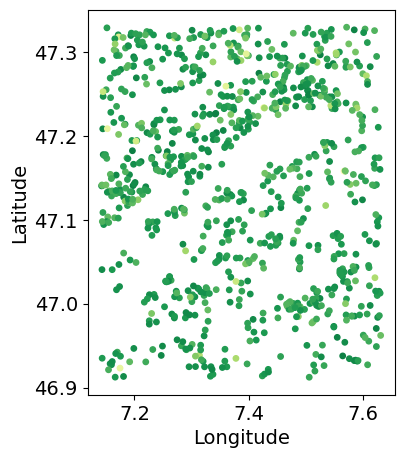

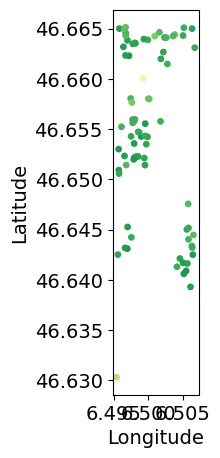

In [58]:
# Jura
fig, axs = plt.subplots(1,1,figsize=(5, 5), sharex=True, sharey=True)

vmin = 0
vmax = 1

gdf_jura.plot(ax=axs, column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=15) 
axs.tick_params(axis='both', labelsize=14)
axs.set_xlabel('Longitude', size=14)
axs.set_ylabel('Latitude', size=14)


fig, axs = plt.subplots(1,1,figsize=(5, 5), sharex=True, sharey=True)

vmin = 0
vmax = 1

gdf_vaud.plot(ax=axs, column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=15) 
axs.tick_params(axis='both', labelsize=14)
axs.set_xlabel('Longitude', size=14)
axs.set_ylabel('Latitude', size=14)

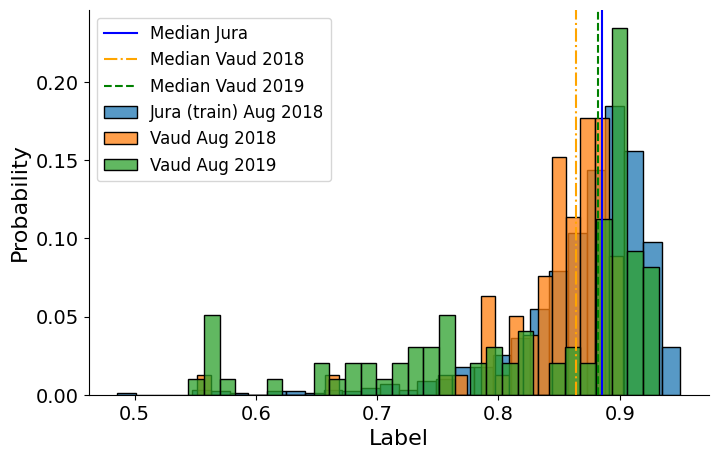

In [24]:
fig, ax = plt.subplots(1,1,figsize=(8, 5), sharex=True, sharey=True)
sns.histplot(ax=ax,data=gdf_jura, x='label', label='Jura (train) Aug 2018', stat='probability', bins=30)
plt.axvline(x =gdf_jura.label.median(), color = 'b', linestyle='-', label='Median Jura')
sns.histplot(ax=ax,data=gdf_vaud, x='label', label='Vaud Aug 2018', stat='probability', bins=30)
plt.axvline(x =gdf_vaud.label.median(), color = 'orange', linestyle='-.', label='Median Vaud 2018')
sns.histplot(ax=ax,data=gdf_none, x='label', label='Vaud Aug 2019', stat='probability', bins=30)
plt.axvline(x =gdf_none.label.median(), color = 'g', linestyle='--', label='Median Vaud 2019')
sns.despine(top=True, right=True)
plt.xlabel('Label', size=16)
plt.ylabel('Probability', size=16)
ax.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=12)

In [25]:
print(gdf_jura.label.median())
print(gdf_vaud.label.median())
print(gdf_none.label.median())

0.88522834
0.8638523
0.881704


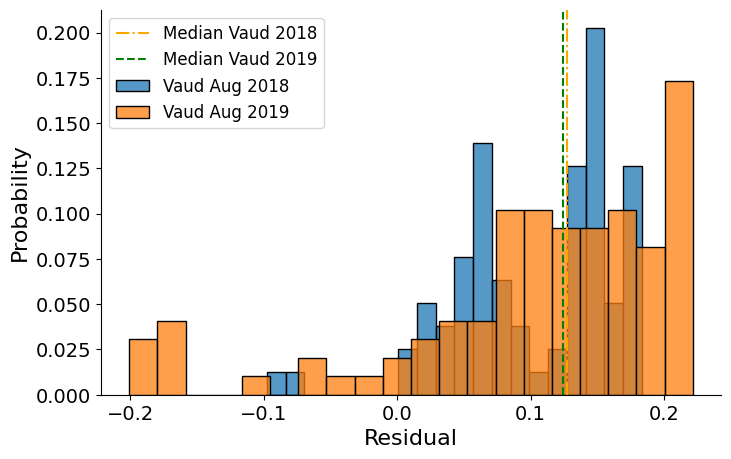

In [27]:
# Plot redids
fig, ax = plt.subplots(1,1,figsize=(8, 5), sharex=True, sharey=True)
#sns.histplot(ax=ax,data=gdf_jura, x='resid', label='Jura (train) Aug 2018', stat='probability', bins=30)
#plt.axvline(x =gdf_jura.resid.median(), color = 'b', linestyle='-', label='Median Jura')
sns.histplot(ax=ax,data=gdf_vaud, x='resid', label='Vaud Aug 2018', stat='probability', bins=20)
plt.axvline(x =gdf_vaud.resid.median(), color = 'orange', linestyle='-.', label='Median Vaud 2018')
sns.histplot(ax=ax,data=gdf_none, x='resid', label='Vaud Aug 2019', stat='probability', bins=20)
plt.axvline(x =gdf_none.resid.median(), color = 'g', linestyle='--', label='Median Vaud 2019')
sns.despine(top=True, right=True)
plt.xlabel('Residual', size=16)
plt.ylabel('Probability', size=16)
ax.tick_params(axis='both', labelsize=14)
plt.legend(fontsize=12)

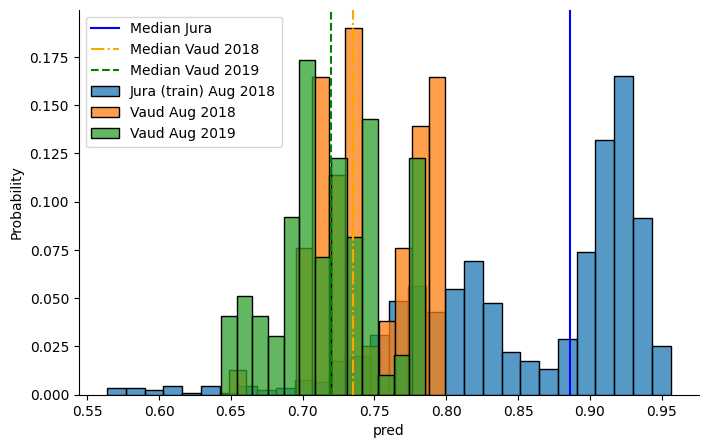

In [39]:
# Plot preds
fig, ax = plt.subplots(1,1,figsize=(8, 5), sharex=True, sharey=True)
sns.histplot(ax=ax,data=gdf_jura, x='pred', label='Jura (train) Aug 2018', stat='probability', bins=30)
plt.axvline(x =gdf_jura.pred.median(), color = 'b', linestyle='-', label='Median Jura')
sns.histplot(ax=ax,data=gdf_vaud, x='pred', label='Vaud Aug 2018', stat='probability', bins=13)
plt.axvline(x =gdf_vaud.pred.median(), color = 'orange', linestyle='-.', label='Median Vaud 2018')
sns.histplot(ax=ax,data=gdf_none, x='pred', label='Vaud Aug 2019', stat='probability', bins=13)
plt.axvline(x =gdf_none.pred.median(), color = 'g', linestyle='--', label='Median Vaud 2019')
sns.despine(top=True, right=True)
plt.legend()

### 2. Vaud drought vs no drought year

In [13]:
# Filter out when abrupt label drop happens
gdf_vaud = gdf[gdf.last_context - gdf.label < 0.1]
# Get drought event (Sep 2018)
gdf_vaud = gdf_vaud[(gdf_vaud.month==8) & (gdf_vaud.year==2018)] 

In [21]:
# Filter out when abrupt label drop happens
gdf_none = gdf[gdf.last_context - gdf.label < 0.1]
# Get NO drought event (Sep 2019)
gdf_none = gdf_none[(gdf_none.month==8) & (gdf_none.year==2019)]

Text(308.3149547119734, 0.5, 'Latitude')

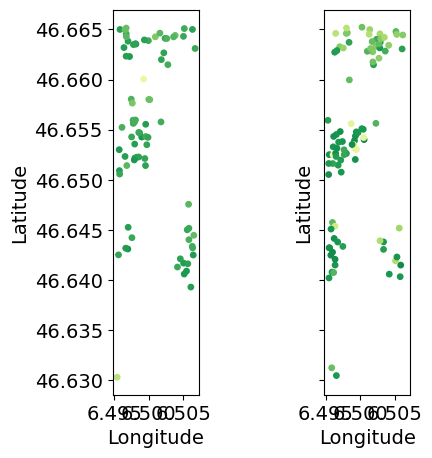

In [67]:
# Vaud
fig, axs = plt.subplots(1,2,figsize=(5, 5), sharex=True, sharey=True)

vmin = 0
vmax = 1

gdf_vaud.plot(ax=axs[0], column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=15) 
axs[0].tick_params(axis='both', labelsize=14)
axs[0].set_xlabel('Longitude', size=14)
axs[0].set_ylabel('Latitude', size=14)


gdf_none.plot(ax=axs[1], column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=15) 
axs[1].tick_params(axis='both', labelsize=14)
axs[1].set_xlabel('Longitude', size=14)
axs[1].set_ylabel('Latitude', size=14)

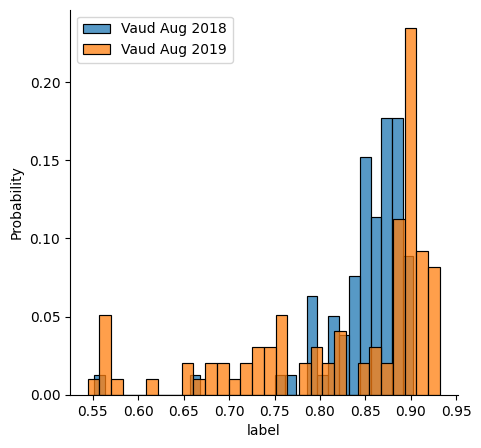

In [68]:
fig, ax = plt.subplots(1,1,figsize=(5, 5), sharex=True, sharey=True)
sns.histplot(ax=ax,data=gdf_vaud, x='label', label='Vaud Aug 2018', stat='probability', bins=30)
sns.histplot(ax=ax,data=gdf_none, x='label', label='Vaud Aug 2019', stat='probability', bins=30)
sns.despine(top=True, right=True)
plt.legend()

## Plot subset of locations

In [71]:
# Find timeseries where context and label low in summer months --> could be drought?
gdf["month"] = gdf["date"].apply(lambda x: int(x.split('-')[1]))
gdf["year"] = gdf["date"].apply(lambda x: int(x.split('-')[0]))
gdf_tmp = gdf[(gdf.month>5) & (gdf.month<10) & (gdf.mean_context<0.5) & (gdf.label<0.5) & (gdf.year==2018)]

In [97]:
# Val set: check for low timeseries and if predictions were ok
gdf_tmp = gdf[(gdf.month>5) & (gdf.month<10) & (gdf.mean_context<0.6)  & (gdf.last_context<0.5) & (gdf.date=='2021-08-17')]

In [98]:
gdf_tmp

date                                      context_dates        lat  \
597  2021-08-17  [2021-05-19, 2021-05-29, 2021-06-08, 2021-06-1...  47.005427   
626  2021-08-17  [2021-05-19, 2021-05-29, 2021-06-08, 2021-06-1...  47.313867   
631  2021-08-17  [2021-05-19, 2021-05-29, 2021-06-08, 2021-06-1...  47.193098   
670  2021-08-17  [2021-05-19, 2021-05-29, 2021-06-08, 2021-06-1...  47.016542   
711  2021-08-17  [2021-05-19, 2021-05-29, 2021-06-08, 2021-06-1...  47.192826   
714  2021-08-17  [2021-05-19, 2021-05-29, 2021-06-08, 2021-06-1...  47.265405   
716  2021-08-17  [2021-05-19, 2021-05-29, 2021-06-08, 2021-06-1...  47.190304   

          lon      pred     label  \
597  7.227029  0.606204  0.577842   
626  7.390106  0.497131  0.334738   
631  7.187816  0.503285  0.666105   
670  7.172137  0.498131  0.423766   
711  7.190798  0.528224  0.658520   
714  7.258529  0.619490  0.560067   
716  7.178690  0.634660  0.627950   

                                          context_ndvi  \
597  [0.4598529, 0.4598529, 0.49678212, 0.5337113, ...   
626  [0.4456022, 0.52658594, 0.5319108, 0.5372357, ...   
631  [0.2287006, 0.514787, 0.6971729, 0.8795587, 0....   
670  [0.42997244, 0.42997244, 0.44077536, 0.4515783...   
711  [0.2278578, 0.42777607, 0.62769437, 0.82761264...   
714  [0.23843089, 0.46376035, 0.6735366, 0.8833129,...   
716  [0.22532944, 0.41914392, 0.6129584, 0.8067729,...   

                     geometry     resid                         wkt  month  \
597  POINT (7.22703 47.00543) -0.028361  POINT (7.227029 47.005427)      8   
626  POINT (7.39011 47.31387) -0.162393  POINT (7.390106 47.313867)      8   
631  POINT (7.18782 47.19310)  0.162820  POINT (7.187816 47.193098)      8   
670  POINT (7.17214 47.01654) -0.074364  POINT (7.172137 47.016542)      8   
711  POINT (7.19080 47.19283)  0.130296  POINT (7.190798 47.192826)      8   
714  POINT (7.25853 47.26541) -0.059422  POINT (7.258529 47.265405)      8   
716  POINT (7.17869 47.19030) -0.006710   POINT (7.17869 47.190304)      8   

     year  mean_context  last_context  
597  2021      0.536052      0.459853  
626  2021      0.469030      0.445602  
631  2021      0.535010      0.228701  
670  2021      0.433037      0.429972  
711  2021      0.565963      0.227858  
714  2021      0.569968      0.238431  
716  2021      0.592059      0.225329

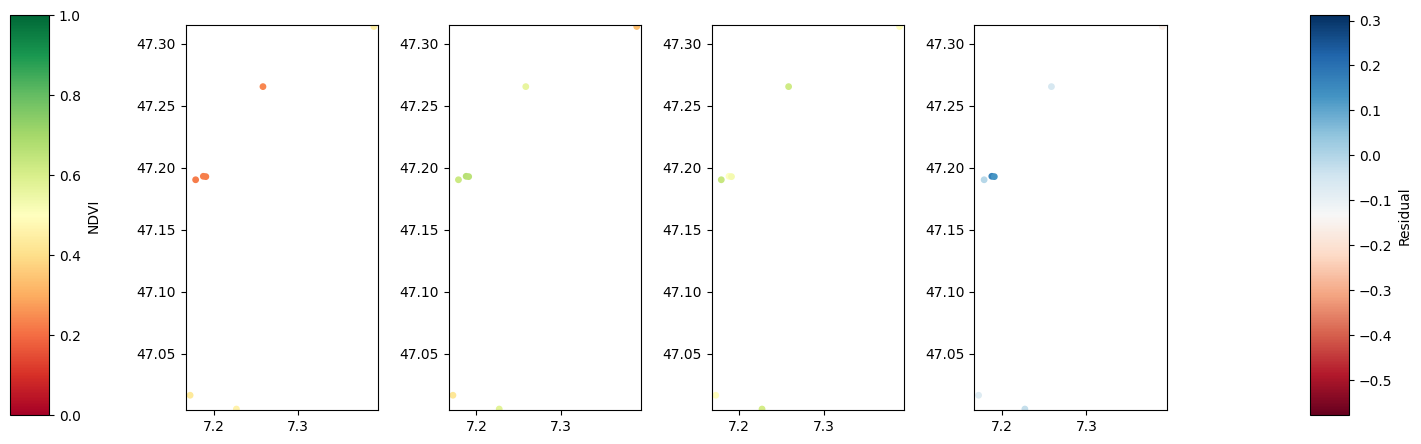

In [99]:
# Plot: locations

#dates = ['2018-08-03', '2018-08-08', '2018-08-18', '2018-08-23', '2018-08-28']
# Or filter for certain dates
#dates = [x for x in unique_dates if x.split('-')[1] in ['06','07','08','09']] #summer months


#date_title = f'{dates[0]} - {dates[-1]} '

fig, axs = plt.subplots(1,4,figsize=(13, 5))

xlim = ([gdf_tmp.total_bounds[0]-0.005,  gdf_tmp.total_bounds[2]+0.005])
ylim = ([gdf_tmp.total_bounds[1]-0.001,  gdf_tmp.total_bounds[3]+0.001])

vmin = 0 #gdf_tmp.label.min()
vmax = 1 #gdf_tmp.label.max()

gdf_tmp.plot(ax=axs[0], column='last_context', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=15) 
#cx.add_basemap(ax=axs[0], crs=gdf.crs.to_string())
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)


gdf_tmp.plot(ax=axs[1], column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=15) 
#cx.add_basemap(ax=axs[0], crs=gdf.crs.to_string())
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)


gdf_tmp.plot(ax=axs[2], column='pred', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=15) 
#cx.add_basemap(ax=axs[1], crs=gdf.crs.to_string())
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)


vmin_resid = gdf.resid.min()
vmax_resid = gdf.resid.max()
gdf_tmp.plot(ax=axs[3], column='resid', cmap='RdBu', vmin=vmin_resid, vmax=vmax_resid, markersize=15) 
axs[3].set_xlim(xlim)
axs[3].set_ylim(ylim)

# Add colorbar
fig = axs[2].get_figure()
cax = fig.add_axes([0, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("NDVI", size=10)

# Add colorbar
fig = axs[3].get_figure()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin_resid, vmax=vmax_resid))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Residual", size=10)

plt.show()

## Plot other rasters in the same bbox

In [ ]:
# Find bbox

In [ ]:
with rasterio.open(forest_mask) as src:
        im_forest = rasterio.open(forest_mask)
        for_arr = im_forest.read(1,  window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))

## Get only one batch

### Load label and prediction

In [35]:
pred_path = f'pixel_data/{exp}/preds/{split}/{setup}_data_cube_b{batch}.pt'
#pred_path = f'pixel_data/{exp}/preds_cp/{split}/{setup}_data_cube_b{batch}.pt'
pred = th.load(pred_path)
pred_ndvi = pred[:,:,0].detach()

In [36]:
img, label = load_batch(batch_size = batch_size, batch_nbr = batch, sample_type = 'pixel_data', split=split, exp=exp, n_timesteps_out=1)

### Get metadata

In [37]:
metadata_path = f'pixel_data/nofilter/{split}/'
split_path = f'/dccstor/cimf/drought_impact/pixel_based/pixel_data/filtered/{split}/'
with open(split_path+'cloud_free_samples.pkl', 'rb') as f:
    cloud_free_samples = pickle.load(f)

In [38]:
# Get date/range of pred
all_loc_dates_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('all_loc_dates')])
full_date_range_files = sorted([f for f in os.listdir(metadata_path) if f.startswith('full_date_range')])

all_loc_dates = []

for f in all_loc_dates_files:
    with open(metadata_path+f, 'rb') as f :
        all_loc_dates += pickle.load(f)
        
full_date_range = []

for f in full_date_range_files:
    with open(metadata_path+f, 'rb') as f :
        full_date_range += pickle.load(f)
        
n_rep = split_size/len(all_loc_dates)
idx_start = int(np.floor((batch_size*batch)/n_rep))
idx_last = int(np.floor((batch_size*batch + batch_size)/n_rep))

In [39]:
# Geolocation
called_samples_file = sorted([f for f in os.listdir(metadata_path) if f.startswith('called_samples')])
called_samples = []

for f in called_samples_file:
    called_samples += th.load(metadata_path+f)

In [40]:
# Get coord and date of pred
df_pred_coords = pd.DataFrame()

for sample_id in range(batch_size):
    
    ndvi_label = label[sample_id, :, 15, :, :].squeeze(1).squeeze(1).numpy()
    ndvi_pred = pred_ndvi[sample_id].detach().cpu()
    
    # If data filtered
    filtered_idx = int(np.floor(cloud_free_samples[batch*batch_size+sample_id]/n_rep))
    dates = all_loc_dates[filtered_idx][3][:1] #is a list
    coords = called_samples[cloud_free_samples[batch*batch_size+sample_id]][0][1:3].detach().numpy() #array
    
    # If not filtered
    #idx = int(np.floor((batch*batch_size+sample_id)/n_rep))
    #dates = all_loc_dates[idx][3][:1]
    #coords = called_samples[batch*batch_size+sample_id][0][1:3].detach().numpy()
    
    df_pred_coords = pd.concat([df_pred_coords, pd.DataFrame({"date":dates, "lat": [coords[1]], "lon": [coords[0]],"pred":ndvi_pred, "label": ndvi_label})], ignore_index=True)

In [41]:
df_pred_coords.head()

date        lat       lon      pred     label
0  2020-08-02  47.176883  7.292558  0.577687  0.496322
1  2020-08-02  46.927108  7.608598  0.721416  0.607033
2  2020-08-02  47.243338  7.541371  0.658629  0.251226
3  2020-08-02  46.997888  7.551055  0.693948  0.499694
4  2020-08-02  46.997156  7.481039  0.706355  0.455869

In [42]:
# Make a geopandas
gdf = gpd.GeoDataFrame(df_pred_coords, geometry=gpd.points_from_xy(df_pred_coords.lon, df_pred_coords.lat))
gdf = gdf.set_crs('epsg:4326')
unique_dates = np.unique(gdf.date)

In [44]:
unique_dates

array(['2020-08-02'], dtype=object)

In [43]:
gdf['resid'] = gdf['label'] - gdf['pred']

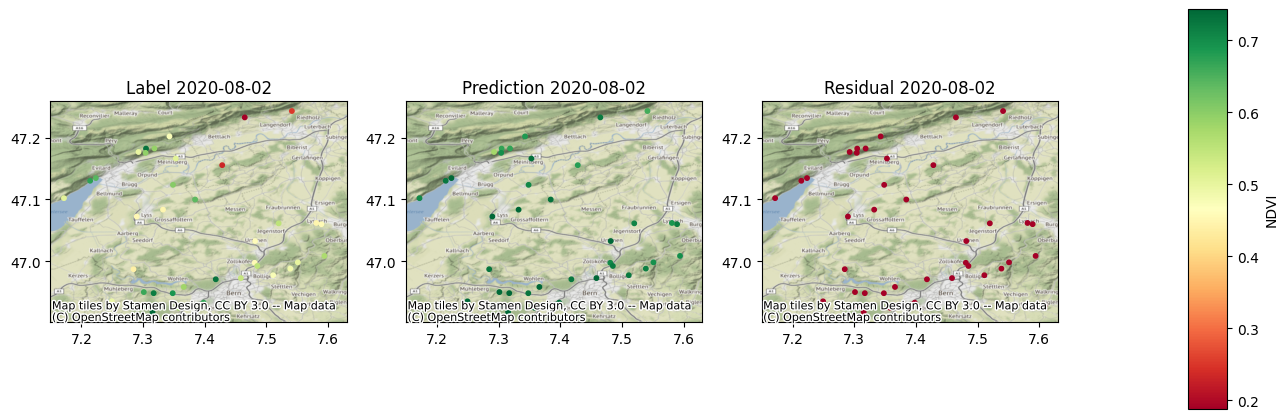

In [47]:
# Plot

fig, axs = plt.subplots(1,3,figsize=(13, 5))

vmin = gdf.label.min()
vmax = gdf.label.max()

date = unique_dates[0]

gdf[gdf.date==date].plot(ax=axs[0], column='label', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=10) 
axs[0].set_title(f'Label {date}')
cx.add_basemap(ax=axs[0], crs=gdf.crs.to_string())

gdf[gdf.date==date].plot(ax=axs[1], column='pred', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=10) 
axs[1].set_title(f'Prediction {date}')
cx.add_basemap(ax=axs[1], crs=gdf.crs.to_string())

gdf[gdf.date==date].plot(ax=axs[2], column='resid', cmap='RdYlGn', vmin=vmin, vmax=vmax, markersize=10) 
axs[2].set_title(f'Residual {date}')
cx.add_basemap(ax=axs[2], crs=gdf.crs.to_string())

# Add colorbar
fig = axs[1].get_figure()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("NDVI", size=10)
plt.show()